---

# Loan Approval Prediction

---
### Overview:

The dataset for loan prediction contains 4269 entries with 13 columns, including `loan_id`, `no_of_dependents`, `education`, `self_employed`, `income_annum`, `loan_amount`, `loan_term`, `cibil_score`, `residential_assets_value`, `commercial_assets_value`, `luxury_assets_value`, `bank_asset_value`, and `loan_status`. All columns are fully populated with no missing values. The data types include 10 integer columns and 3 object (categorical) columns (`education`, `self_employed`, and `loan_status`). Memory usage is approximately 433.7 KB.

Key features include:
- `income_annum`: Annual income ranging from 410,000 to 960,000.
- `loan_amount`: Loan amounts vary from 12,200,000 to 30,700,000.
- `loan_term`: Loan duration in years, with values like 8, 4, 2, and 5 observed.
- `cibil_score`: Credit scores, e.g., 717, 749, 705, 671.
- `assets_value`: Residential, commercial, luxury, and bank assets range widely, e.g., 2,200,000 to 24,000,000 for residential assets.
- `loan_status`: Binary outcome ('Approved' or 'Rejected'), with examples showing diverse financial profiles leading to both outcomes.

This dataset provides a comprehensive basis for predicting loan approval, capturing financial health, creditworthiness, and demographic factors.


---

## Imports

---

In [70]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import f_classif, mutual_info_classif
from scipy.stats import kendalltau
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  precision_score, recall_score, f1_score, confusion_matrix


from scipy.stats import chi2_contingency, kendalltau


---

## Initial Data Inspection
Load the dataset and take a first look at its structure.

---


In [71]:
data = pd.read_csv('loan_approval_dataset.csv')

In [72]:
data.head(4)

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected


In [73]:
data.columns

Index(['loan_id', ' no_of_dependents', ' education', ' self_employed',
       ' income_annum', ' loan_amount', ' loan_term', ' cibil_score',
       ' residential_assets_value', ' commercial_assets_value',
       ' luxury_assets_value', ' bank_asset_value', ' loan_status'],
      dtype='object')

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


In [75]:
data.describe()

,loan_id,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
count,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03
mean,2135.000000,2.498712,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06
std,1232.498479,1.695910,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06
min,1.000000,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00
25%,1068.000000,1.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06
50%,2135.000000,3.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06
75%,3202.000000,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06
max,4269.000000,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07


---

## Data Cleaning
Clean the data by handling missing values, duplicates, or formatting issues.

---

In [76]:
data.isnull().sum()

loan_id                      0
 no_of_dependents            0
 education                   0
 self_employed               0
 income_annum                0
 loan_amount                 0
 loan_term                   0
 cibil_score                 0
 residential_assets_value    0
 commercial_assets_value     0
 luxury_assets_value         0
 bank_asset_value            0
 loan_status                 0
dtype: int64

In [77]:
data.duplicated().sum()

0

In [78]:
data.dtypes

loan_id                       int64
 no_of_dependents             int64
 education                   object
 self_employed               object
 income_annum                 int64
 loan_amount                  int64
 loan_term                    int64
 cibil_score                  int64
 residential_assets_value     int64
 commercial_assets_value      int64
 luxury_assets_value          int64
 bank_asset_value             int64
 loan_status                 object
dtype: object

---

## Exploratory Data Analysis (EDA)
Visualize and summarize the data to uncover patterns and insights.

---

In [79]:
plt.style.use('default')
sns.set_palette("husl")

print("DATASET ANALYSIS")
print("="*60)
print("Dataset Info:")
print(f"Shape: {data.shape}")
print(f"Columns: {list(data.columns)}")
print("\nColumn Types:")
print(data.dtypes)
print("="*60)

if 'loan_id' in data.columns:
    data_clean = data.drop('loan_id', axis=1)
    print("Dropped 'loan_id' column")
else:
    data_clean = data.copy()
    print("No 'loan_id' column found, using all columns")

categorical_columns = []
numerical_columns = []

for col in data_clean.columns:
    if data_clean[col].dtype == 'object':
        categorical_columns.append(col)
    else:
        numerical_columns.append(col)

print(f"\nAuto-detected columns:")
print(f"Categorical columns ({len(categorical_columns)}): {categorical_columns}")
print(f"Numerical columns ({len(numerical_columns)}): {numerical_columns}")
print("="*60)

DATASET ANALYSIS
Dataset Info:
Shape: (4269, 13)
Columns: ['loan_id', ' no_of_dependents', ' education', ' self_employed', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value', ' loan_status']

Column Types:
loan_id                       int64
 no_of_dependents             int64
 education                   object
 self_employed               object
 income_annum                 int64
 loan_amount                  int64
 loan_term                    int64
 cibil_score                  int64
 residential_assets_value     int64
 commercial_assets_value      int64
 luxury_assets_value          int64
 bank_asset_value             int64
 loan_status                 object
dtype: object
Dropped 'loan_id' column

Auto-detected columns:
Categorical columns (3): [' education', ' self_employed', ' loan_status']
Numerical columns (9): [' no_of_dependents', ' income_annum', ' loan_amount'


CATEGORICAL COLUMNS ANALYSIS
----------------------------------------


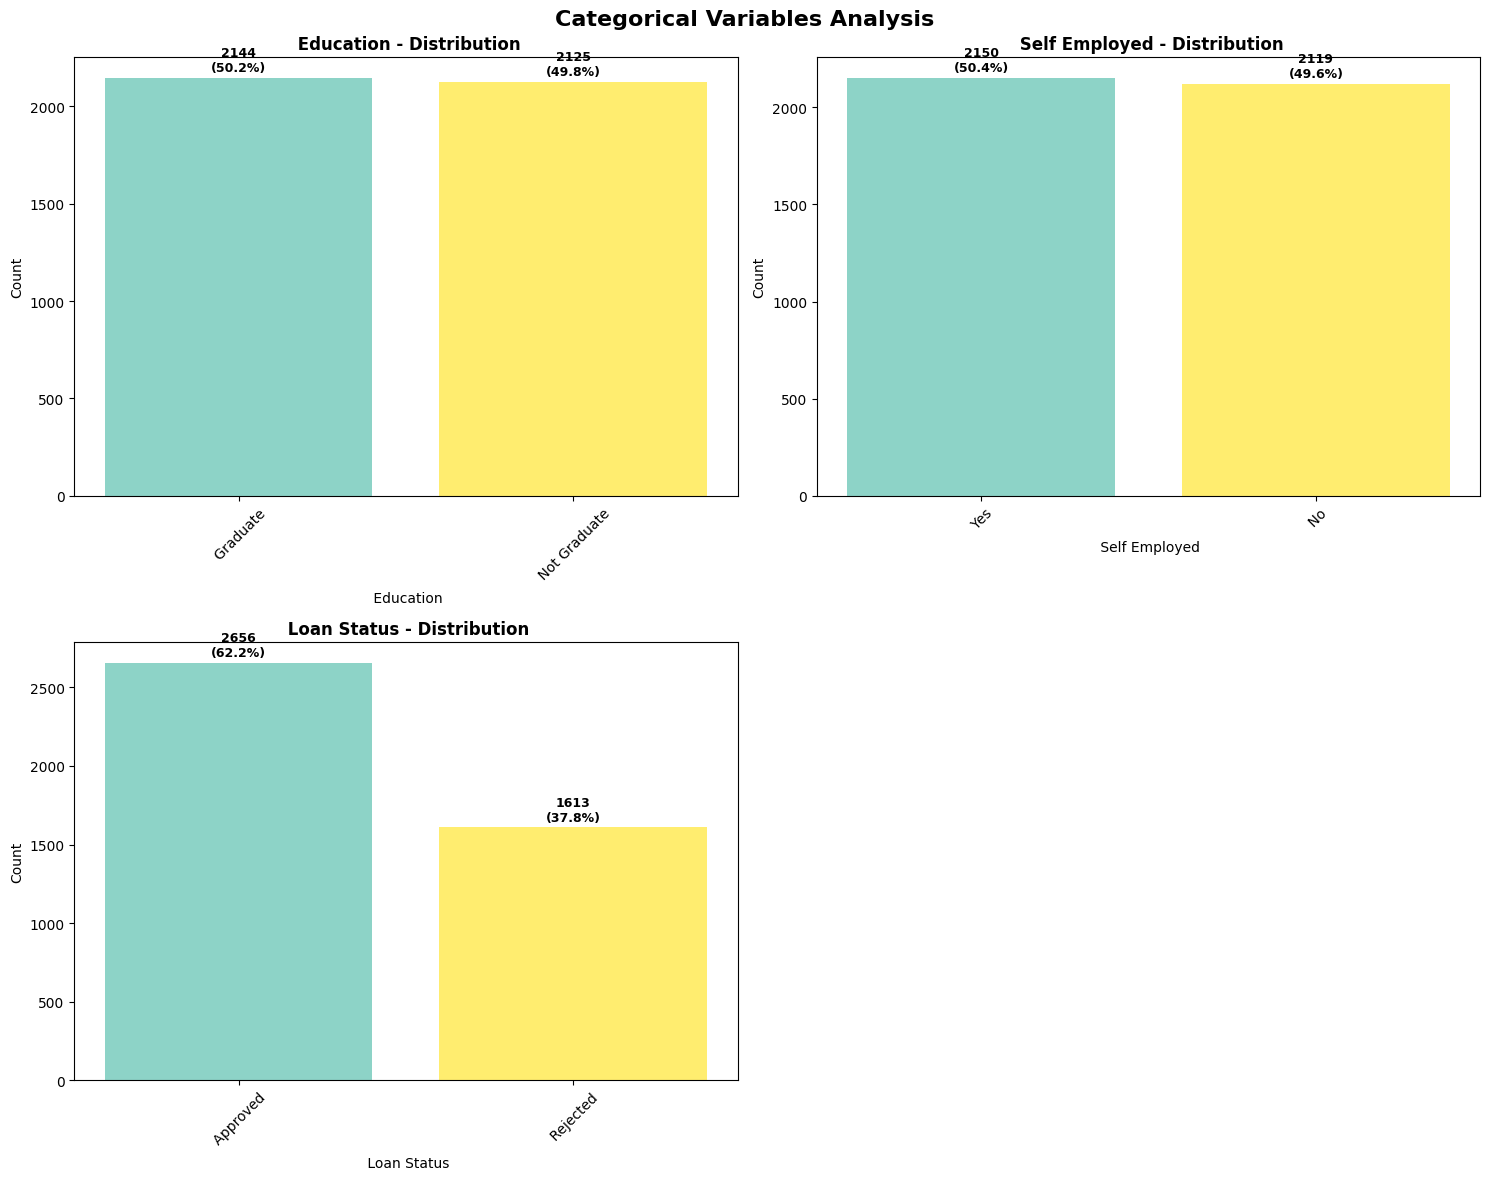

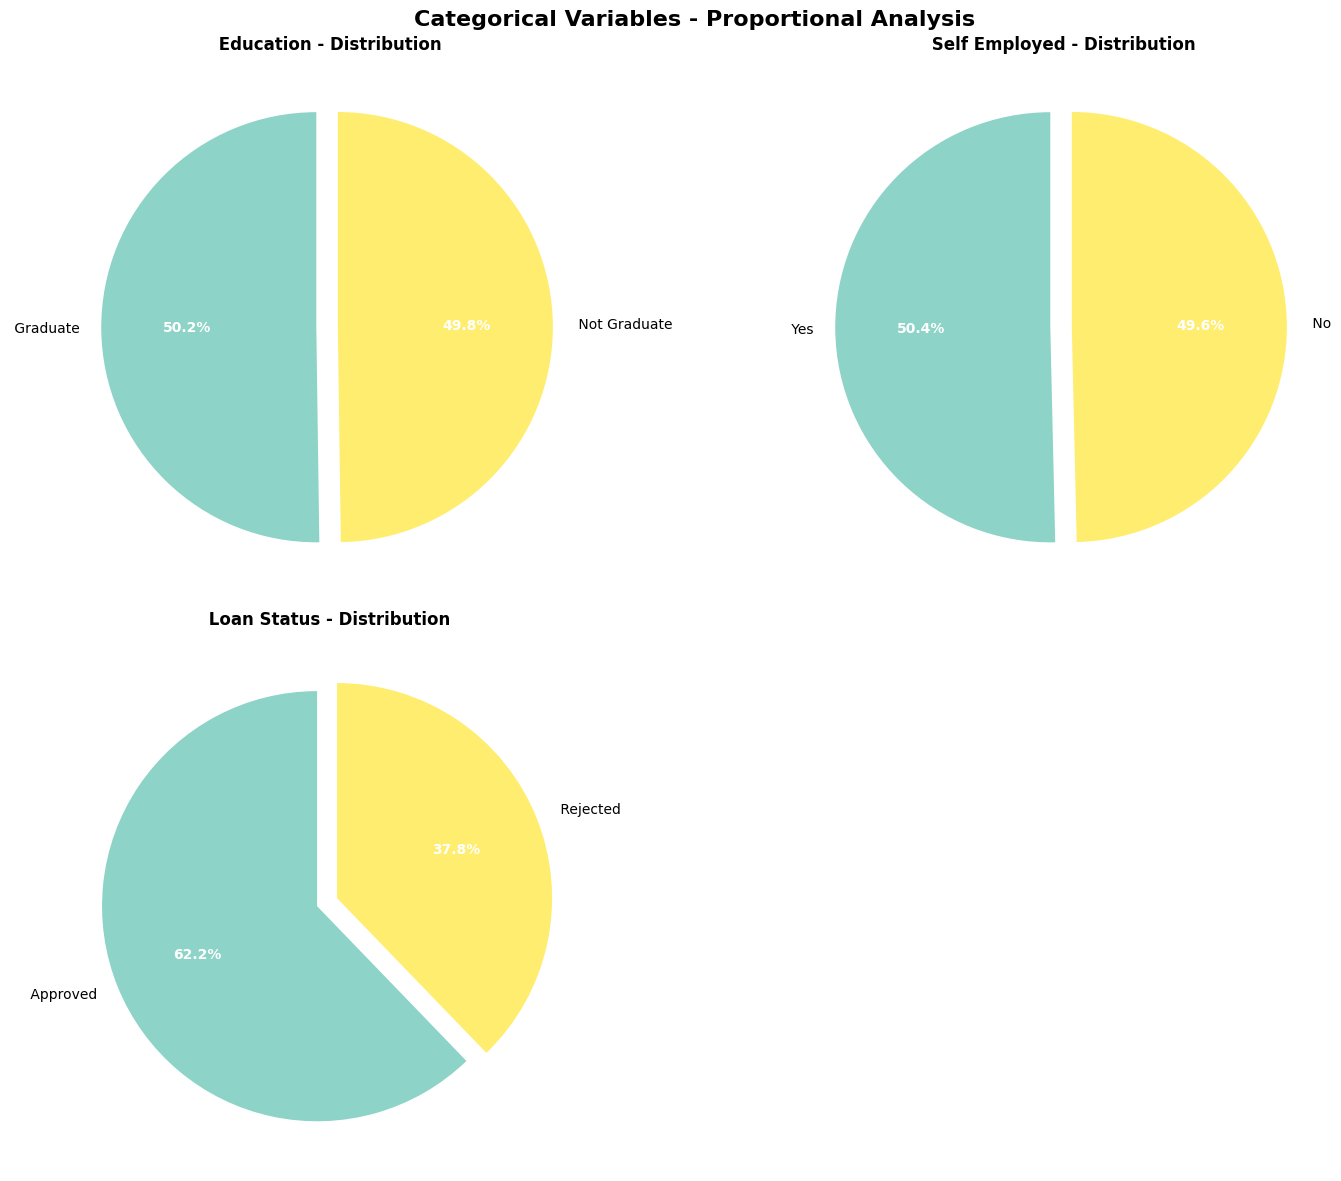


Categorical Variables Summary:

 EDUCATION:
   Graduate: 2144 (50.22%)
   Not Graduate: 2125 (49.78%)

 SELF_EMPLOYED:
   Yes: 2150 (50.36%)
   No: 2119 (49.64%)

 LOAN_STATUS:
   Approved: 2656 (62.22%)
   Rejected: 1613 (37.78%)


In [80]:
if len(categorical_columns) > 0:
    print("\nCATEGORICAL COLUMNS ANALYSIS")
    print("-" * 40)
    
    n_cat_cols = len(categorical_columns)
    cat_rows = (n_cat_cols + 1) // 2
    cat_cols = 2
    
    fig_cat, axes_cat = plt.subplots(cat_rows, cat_cols, figsize=(15, 6*cat_rows))
    fig_cat.suptitle('Categorical Variables Analysis', fontsize=16, fontweight='bold', y=0.98)
    
    if n_cat_cols > 1:
        axes_cat = axes_cat.flatten()
    else:
        axes_cat = [axes_cat]
    
    for i, col in enumerate(categorical_columns):
        if i < len(axes_cat):
            value_counts = data_clean[col].value_counts()
            bars = axes_cat[i].bar(range(len(value_counts)), value_counts.values, 
                                  color=plt.cm.Set3(np.linspace(0, 1, len(value_counts))))
            axes_cat[i].set_title(f'{col.title().replace("_", " ")} - Distribution', 
                                 fontweight='bold', fontsize=12)
            axes_cat[i].set_xlabel(col.title().replace("_", " "))
            axes_cat[i].set_ylabel('Count')
            axes_cat[i].set_xticks(range(len(value_counts)))
            axes_cat[i].set_xticklabels(value_counts.index, rotation=45)
            
            for bar, count in zip(bars, value_counts.values):
                height = bar.get_height()
                axes_cat[i].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                               f'{count}\n({count/len(data_clean)*100:.1f}%)',
                               ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    for i in range(n_cat_cols, len(axes_cat)):
        axes_cat[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    fig_pie, axes_pie = plt.subplots(cat_rows, cat_cols, figsize=(15, 6*cat_rows))
    fig_pie.suptitle('Categorical Variables - Proportional Analysis', fontsize=16, fontweight='bold', y=0.98)
    
    if n_cat_cols > 1:
        axes_pie = axes_pie.flatten()
    else:
        axes_pie = [axes_pie]
    
    for i, col in enumerate(categorical_columns):
        if i < len(axes_pie):
            value_counts = data_clean[col].value_counts()
            colors = plt.cm.Set3(np.linspace(0, 1, len(value_counts)))
            
            wedges, texts, autotexts = axes_pie[i].pie(value_counts.values, 
                                                      labels=value_counts.index,
                                                      autopct='%1.1f%%',
                                                      colors=colors,
                                                      startangle=90,
                                                      explode=[0.05]*len(value_counts))
            
            axes_pie[i].set_title(f'{col.title().replace("_", " ")} - Distribution', 
                                 fontweight='bold', fontsize=12)
            
            for autotext in autotexts:
                autotext.set_color('white')
                autotext.set_fontweight('bold')
    
    for i in range(n_cat_cols, len(axes_pie)):
        axes_pie[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    print("\nCategorical Variables Summary:")
    for col in categorical_columns:
        print(f"\n{col.upper()}:")
        value_counts = data_clean[col].value_counts()
        percentages = (value_counts / len(data_clean) * 100).round(2)
        for value, count, pct in zip(value_counts.index, value_counts.values, percentages):
            print(f"  {value}: {count} ({pct}%)")


##### Categorical Variables Distribution Analysis

The dataset's categorical variables reveal balanced distributions across key attributes. Education is nearly evenly split, with 2144 (50.22%) graduates and 2125 (49.78%) non-graduates. Self-employment status is similarly balanced, with 2150 (50.36%) individuals self-employed and 2119 (49.64%) not self-employed. Loan status shows a stronger skew, with 2656 (62.22%) loans approved and 1613 (37.78%) rejected, indicating a majority approval rate.



NUMERICAL COLUMNS ANALYSIS
----------------------------------------


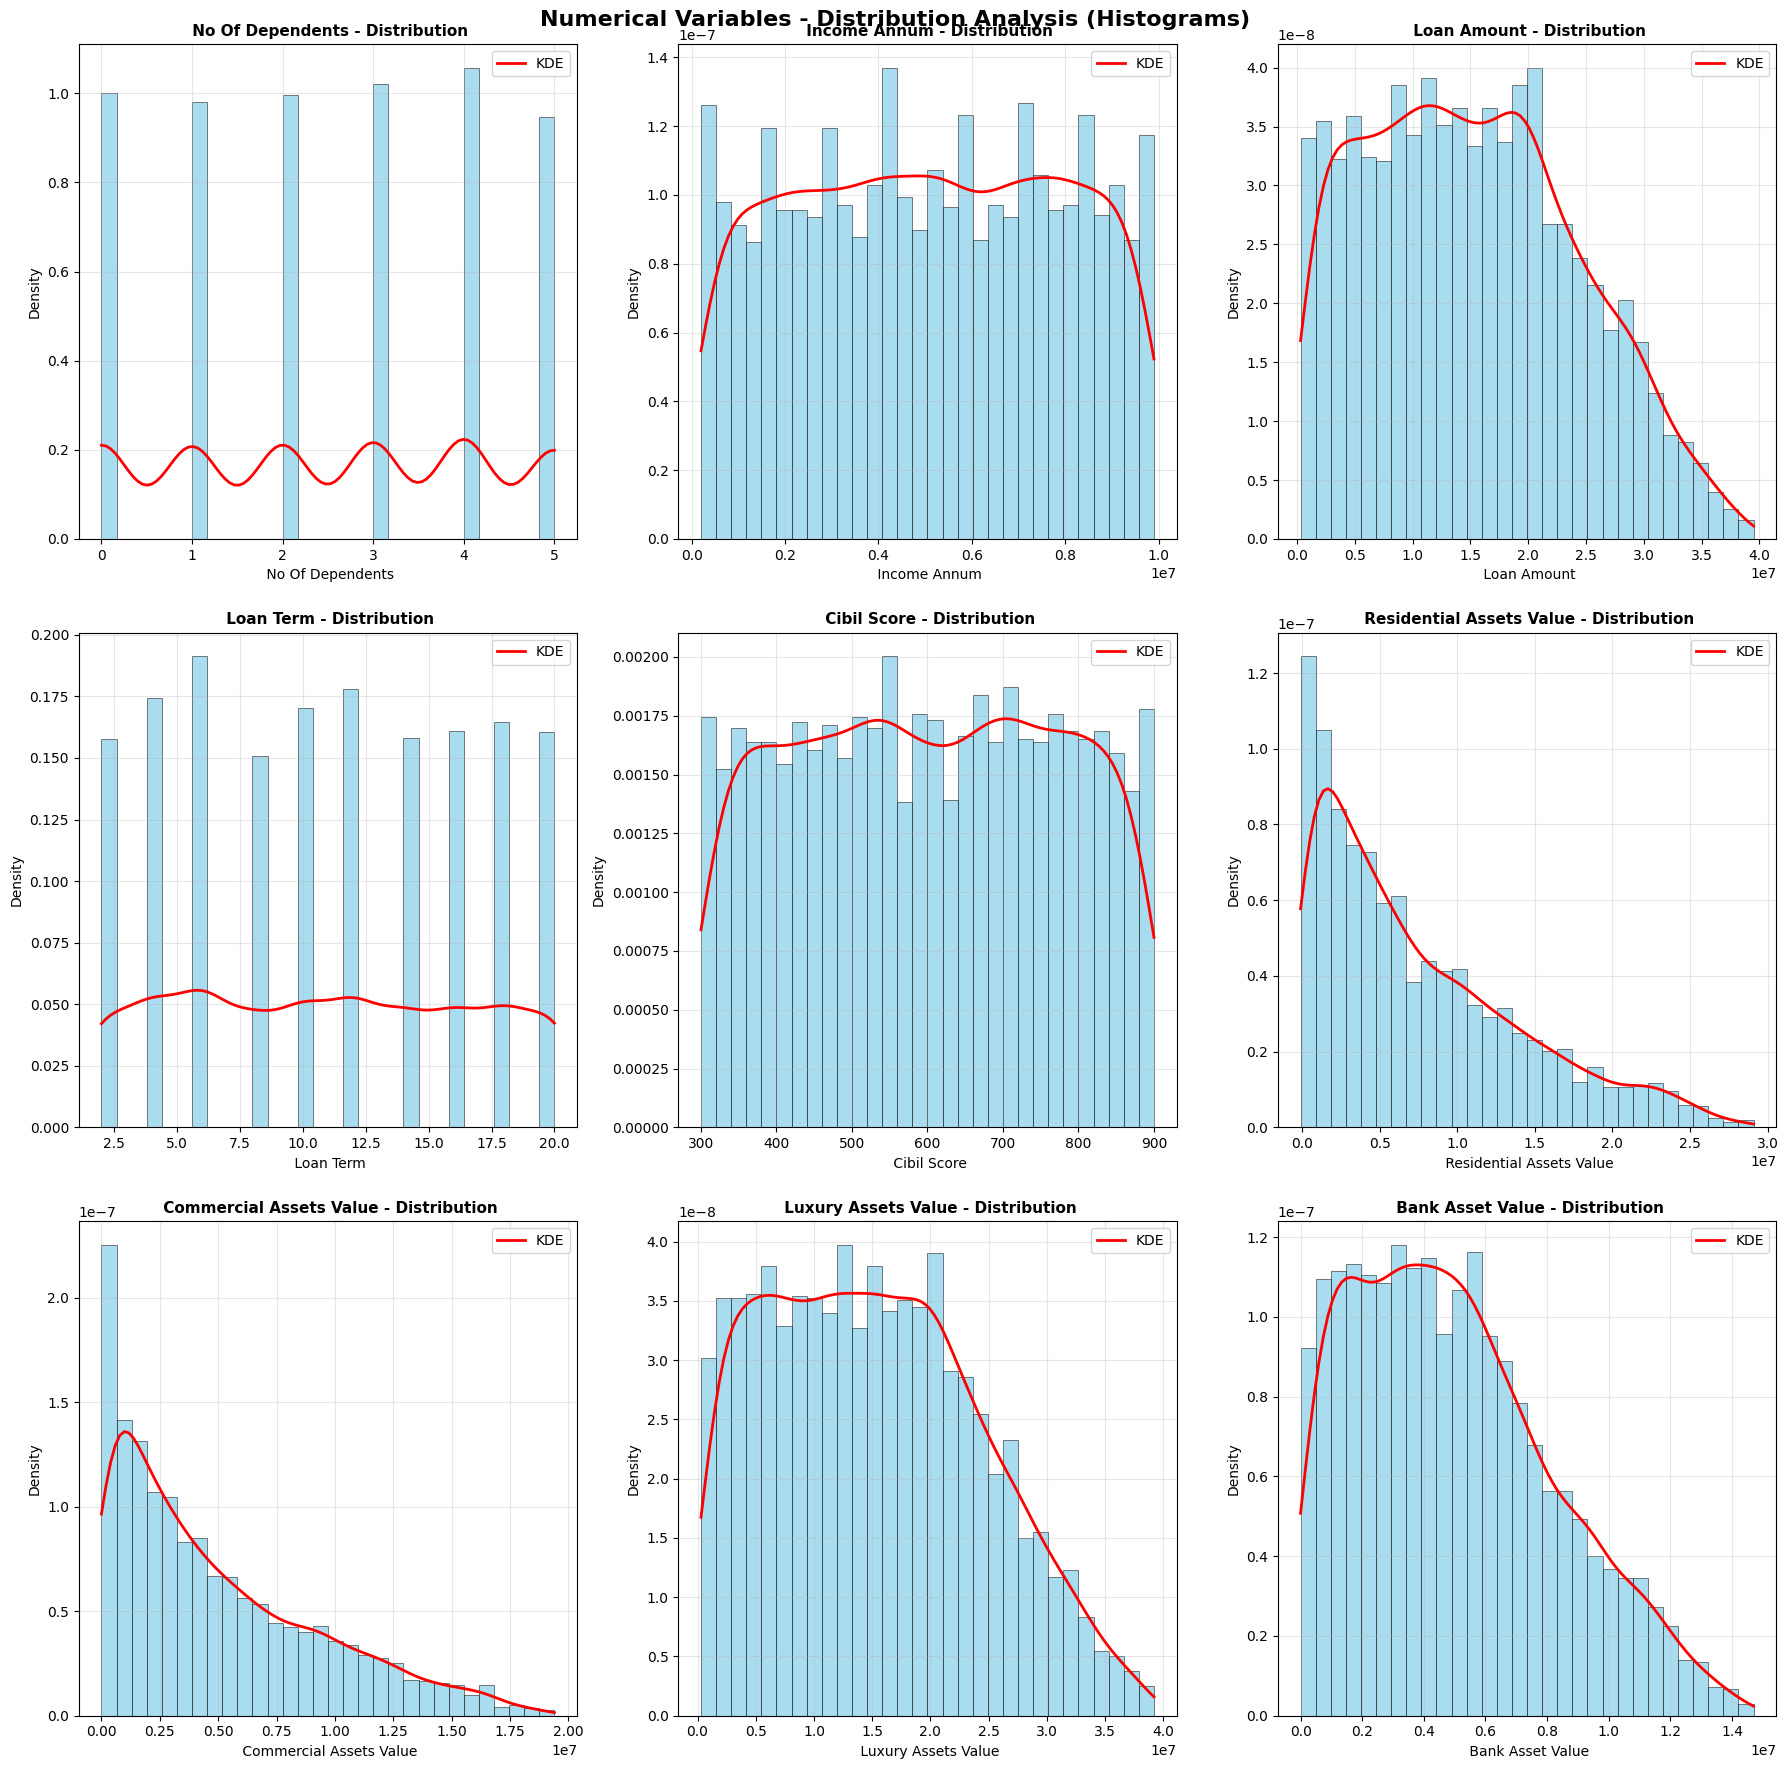

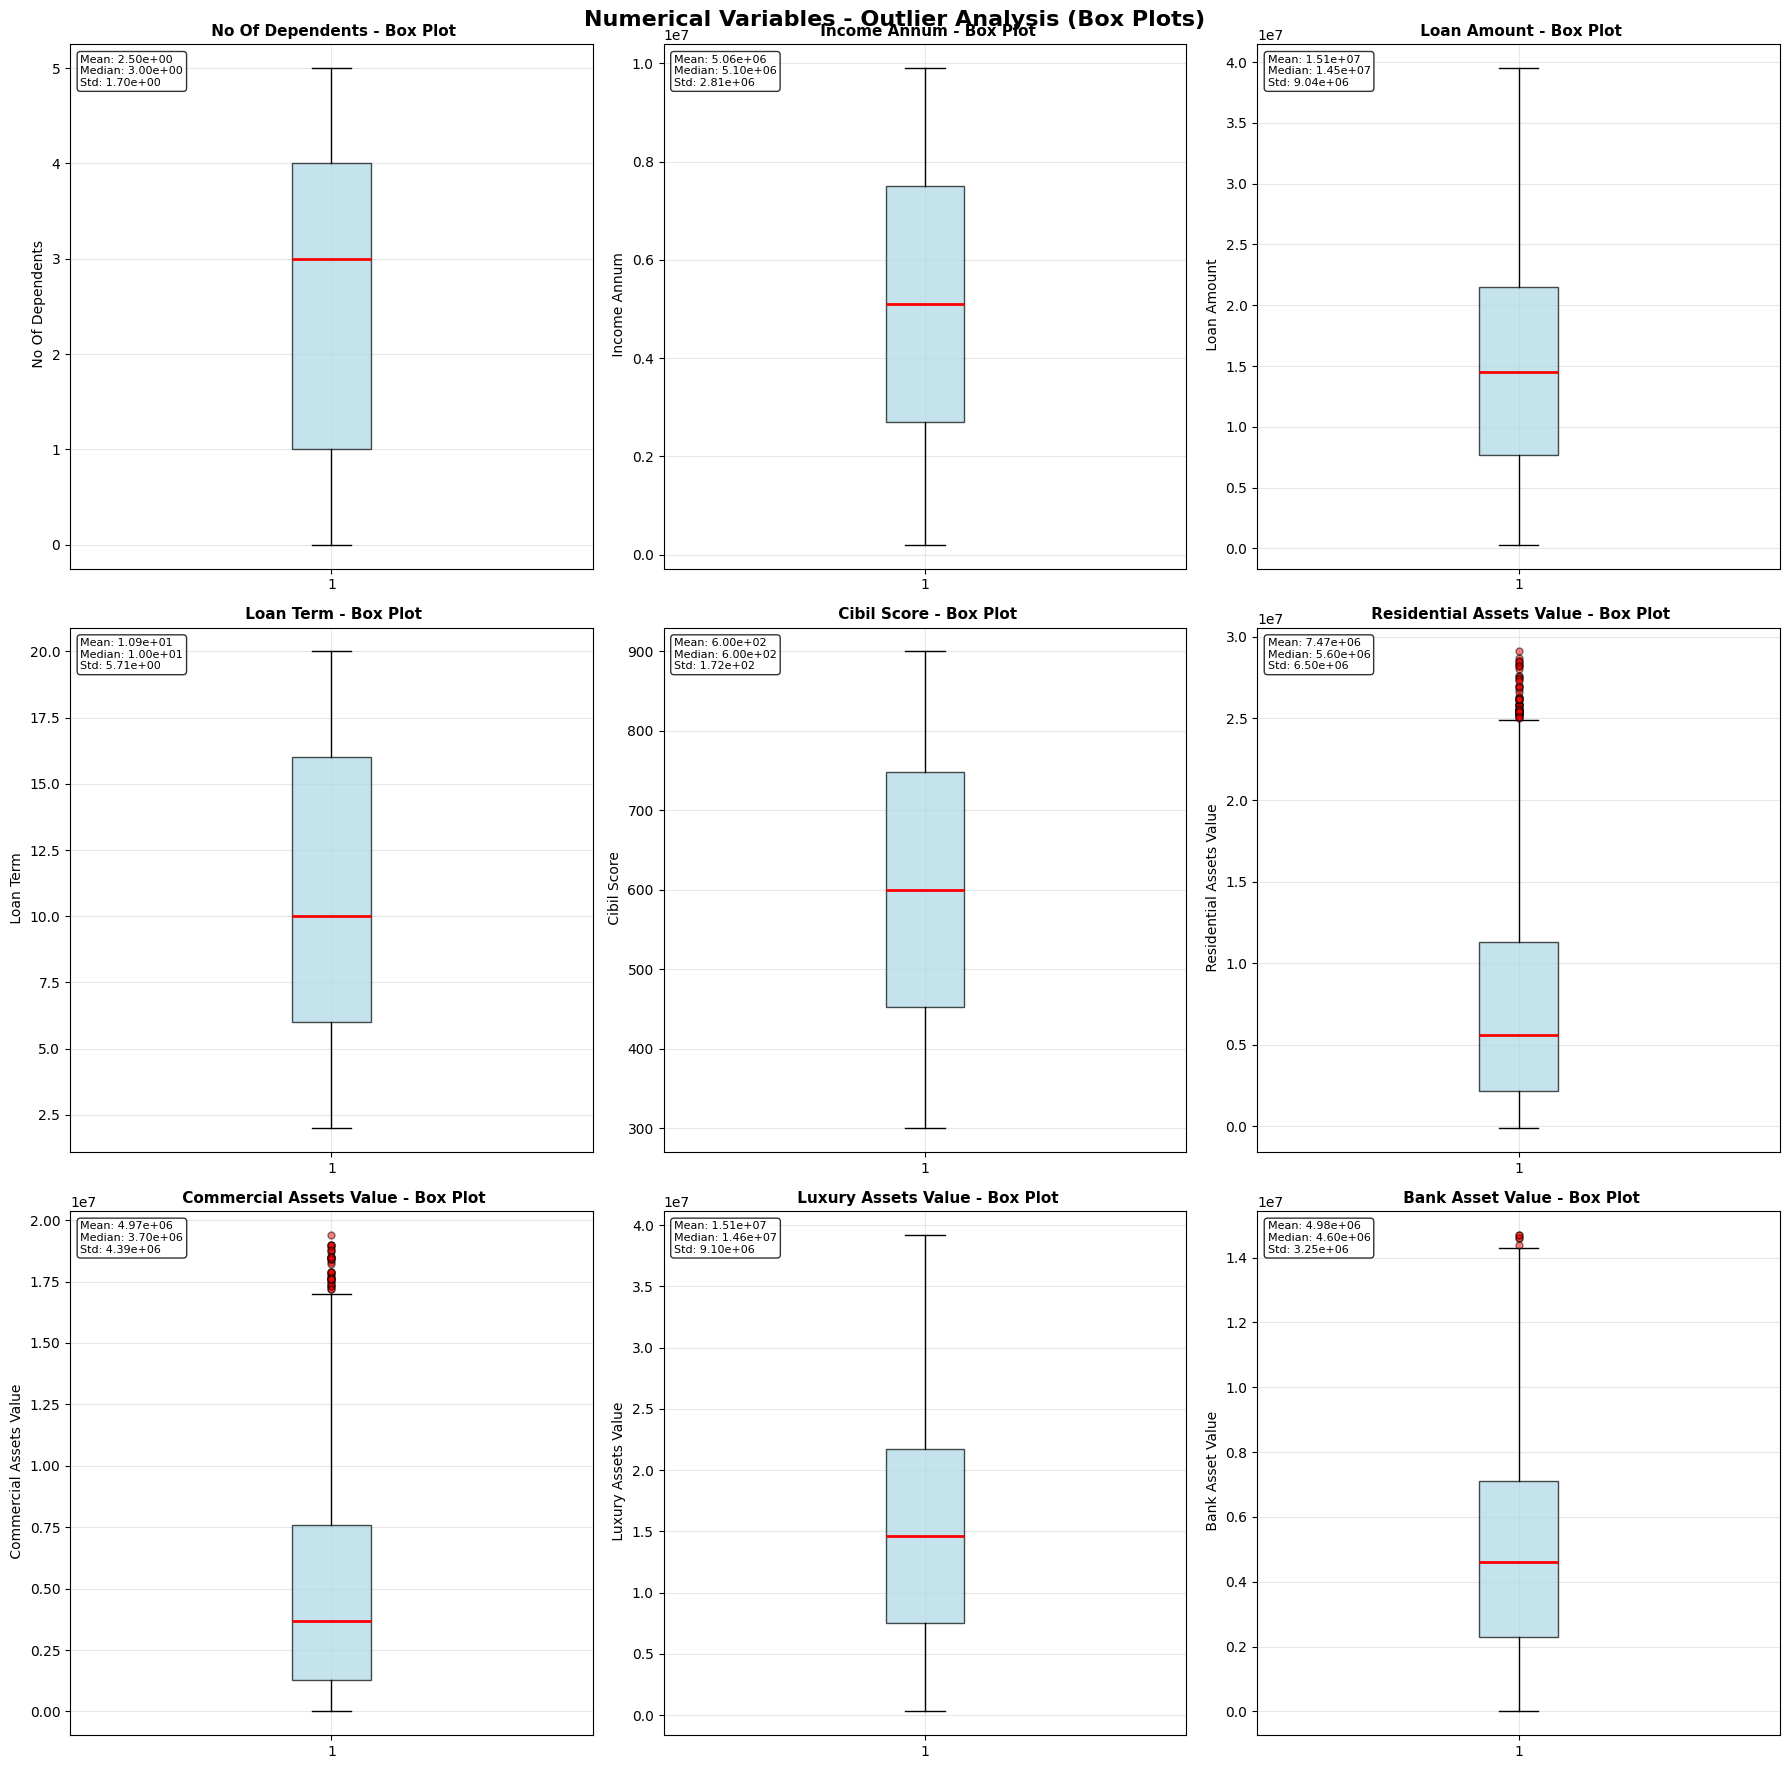


Numerical Variables Summary Statistics:
          no_of_dependents  income_annum  loan_amount  loan_term  cibil_score  \
count             4.27e+03      4.27e+03     4.27e+03   4.27e+03     4.27e+03   
mean              2.50e+00      5.06e+06     1.51e+07   1.09e+01     6.00e+02   
std               1.70e+00      2.81e+06     9.04e+06   5.71e+00     1.72e+02   
min               0.00e+00      2.00e+05     3.00e+05   2.00e+00     3.00e+02   
25%               1.00e+00      2.70e+06     7.70e+06   6.00e+00     4.53e+02   
50%               3.00e+00      5.10e+06     1.45e+07   1.00e+01     6.00e+02   
75%               4.00e+00      7.50e+06     2.15e+07   1.60e+01     7.48e+02   
max               5.00e+00      9.90e+06     3.95e+07   2.00e+01     9.00e+02   
skewness         -1.80e-02     -1.28e-02     3.09e-01   3.63e-02    -9.04e-03   
kurtosis         -1.26e+00     -1.18e+00    -7.44e-01  -1.22e+00    -1.19e+00   

          residential_assets_value  commercial_assets_value  \
coun

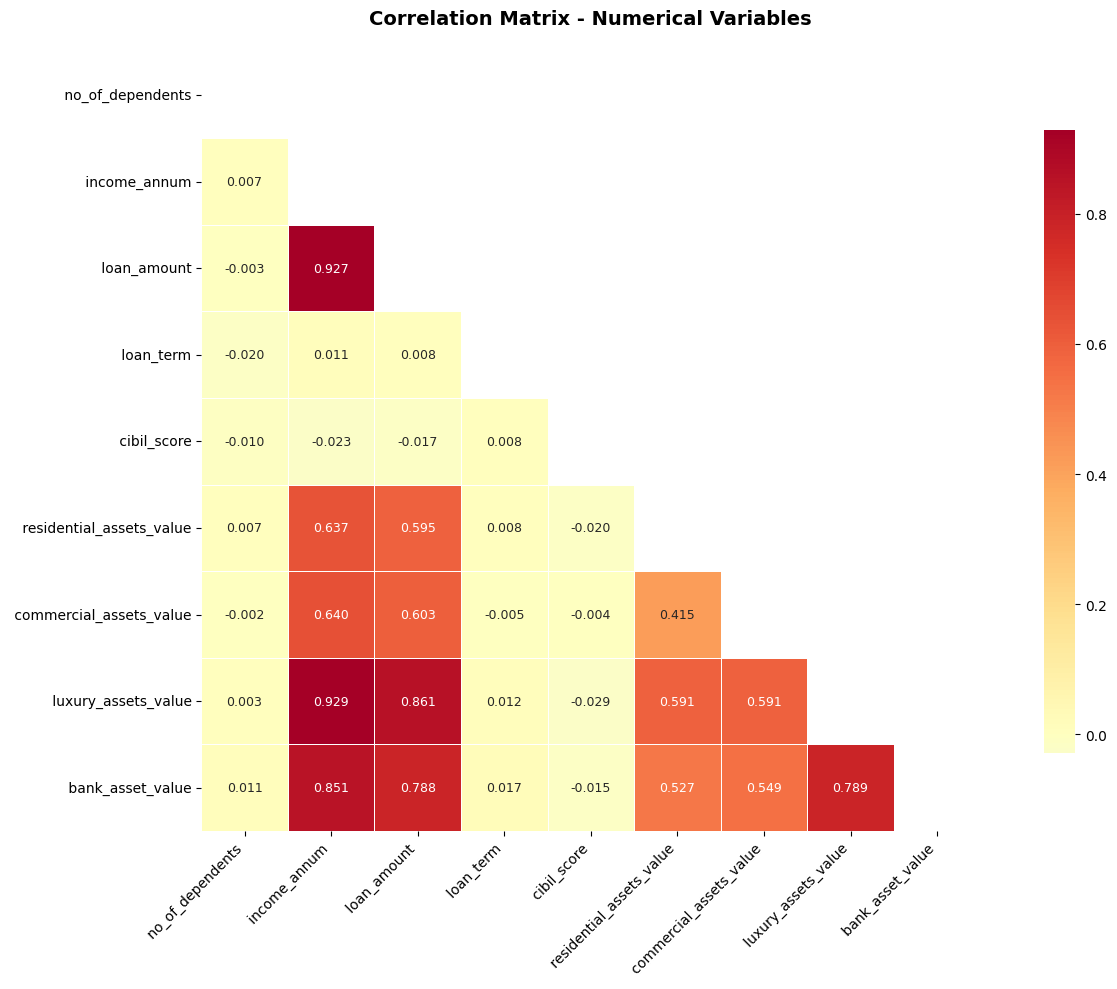

Highly Correlated Variable Pairs (|correlation| > 0.7):
   income_annum ↔  loan_amount: 0.927
   income_annum ↔  luxury_assets_value: 0.929
   income_annum ↔  bank_asset_value: 0.851
   loan_amount ↔  luxury_assets_value: 0.861
   loan_amount ↔  bank_asset_value: 0.788
   luxury_assets_value ↔  bank_asset_value: 0.789

VISUALIZATION COMPLETE!


In [81]:
if len(numerical_columns) > 0:
    print("\n\nNUMERICAL COLUMNS ANALYSIS")
    print("-" * 40)
    
    n_num_cols = len(numerical_columns)
    num_rows = (n_num_cols + 2) // 3
    num_cols = 3
    
    fig_hist, axes_hist = plt.subplots(num_rows, num_cols, figsize=(18, 6*num_rows))
    fig_hist.suptitle('Numerical Variables - Distribution Analysis (Histograms)', 
                      fontsize=16, fontweight='bold', y=0.98)
    
    axes_hist = axes_hist.flatten() if n_num_cols > 1 else [axes_hist]
    
    for i, col in enumerate(numerical_columns):
        if i < len(axes_hist):
            axes_hist[i].hist(data_clean[col], bins=30, alpha=0.7, color='skyblue', 
                             density=True, edgecolor='black', linewidth=0.5)
            
            try:
                kde_x = np.linspace(data_clean[col].min(), data_clean[col].max(), 100)
                kde = stats.gaussian_kde(data_clean[col])
                axes_hist[i].plot(kde_x, kde(kde_x), color='red', linewidth=2, label='KDE')
            except:
                pass
            
            axes_hist[i].set_title(f'{col.title().replace("_", " ")} - Distribution', 
                                  fontweight='bold', fontsize=11)
            axes_hist[i].set_xlabel(col.title().replace("_", " "))
            axes_hist[i].set_ylabel('Density')
            axes_hist[i].grid(True, alpha=0.3)
            axes_hist[i].legend()
    
    for i in range(n_num_cols, len(axes_hist)):
        axes_hist[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    fig_box, axes_box = plt.subplots(num_rows, num_cols, figsize=(18, 6*num_rows))
    fig_box.suptitle('Numerical Variables - Outlier Analysis (Box Plots)', 
                     fontsize=16, fontweight='bold', y=0.98)
    
    axes_box = axes_box.flatten() if n_num_cols > 1 else [axes_box]
    
    for i, col in enumerate(numerical_columns):
        if i < len(axes_box):
            box_plot = axes_box[i].boxplot(data_clean[col], patch_artist=True, 
                                          boxprops=dict(facecolor='lightblue', alpha=0.7),
                                          medianprops=dict(color='red', linewidth=2),
                                          flierprops=dict(marker='o', markerfacecolor='red', 
                                                        markersize=5, alpha=0.5))
            
            axes_box[i].set_title(f'{col.title().replace("_", " ")} - Box Plot', 
                                 fontweight='bold', fontsize=11)
            axes_box[i].set_ylabel(col.title().replace("_", " "))
            axes_box[i].grid(True, alpha=0.3)
            
            q1, median, q3 = np.percentile(data_clean[col], [25, 50, 75])
            mean_val = data_clean[col].mean()
            std_val = data_clean[col].std()
            
            stats_text = f'Mean: {mean_val:.2e}\nMedian: {median:.2e}\nStd: {std_val:.2e}'
            axes_box[i].text(0.02, 0.98, stats_text, transform=axes_box[i].transAxes,
                            verticalalignment='top', bbox=dict(boxstyle='round', 
                            facecolor='white', alpha=0.8), fontsize=8)
    
    for i in range(n_num_cols, len(axes_box)):
        axes_box[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    print("\nNumerical Variables Summary Statistics:")
    print("=" * 80)
    
    summary_stats = data_clean[numerical_columns].describe()
    
    additional_stats = pd.DataFrame(index=['skewness', 'kurtosis'])
    for col in numerical_columns:
        additional_stats.loc['skewness', col] = stats.skew(data_clean[col])
        additional_stats.loc['kurtosis', col] = stats.kurtosis(data_clean[col])
    
    full_summary = pd.concat([summary_stats, additional_stats])
    
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.float_format', '{:.2e}'.format)
    
    print(full_summary)
    
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    
    if len(numerical_columns) > 1:
        print("\n\nCORRELATION ANALYSIS")
        print("-" * 40)
        
        correlation_matrix = data_clean[numerical_columns].corr()
        
        plt.figure(figsize=(14, 10))
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        heatmap = sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', 
                              center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .8},
                              fmt='.3f', annot_kws={'size': 9})
        plt.title('Correlation Matrix - Numerical Variables', fontweight='bold', fontsize=14, pad=20)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        print("Highly Correlated Variable Pairs (|correlation| > 0.7):")
        high_corr_pairs = []
        for i in range(len(correlation_matrix.columns)):
            for j in range(i+1, len(correlation_matrix.columns)):
                corr_val = correlation_matrix.iloc[i, j]
                if abs(corr_val) > 0.7:
                    high_corr_pairs.append((correlation_matrix.columns[i], 
                                           correlation_matrix.columns[j], 
                                           corr_val))
        
        if high_corr_pairs:
            for var1, var2, corr in high_corr_pairs:
                print(f"  {var1} ↔ {var2}: {corr:.3f}")
        else:
            print("  No highly correlated pairs found (threshold: |correlation| > 0.7)")

print("\n" + "="*60)
print("VISUALIZATION COMPLETE!")
print("="*60)

##### Numerical Variables Distribution Analysis

The dataset's numerical variables exhibit diverse distributions and strong financial interdependencies, as summarized below:

| Variable                | Mean         | Median       | Distribution         | Range         | Outliers | Notes                              |
|-------------------------|--------------|--------------|----------------------|---------------|----------|------------------------------------|
| Number of Dependents    | 2.5          | 3            | Slightly negative skew| 0–5           | Yes      | Peaks at 3                         |
| Income per Annum        | 5.06M        | 5.1M         | Near-normal, slight negative skew | - | Yes      | Moderate spread                    |
| Loan Amount             | 15.1M        | 14.5M        | Right-skewed         | -             | Yes      | Wide range                         |
| Loan Term               | 10.9 years   | 10 years     | Uniform              | 2–20 years    | Some     | -                                  |
| Cibil Score             | 600          | 600          | Symmetric            | -             | Minimal  | Tight interquartile range          |
| Residential Assets      | 7.47M        | -            | Right-skewed         | -             | Yes      | Long tail                          |
| Commercial Assets       | 4.97M        | -            | Right-skewed         | -             | Yes      | -                                  |
| Luxury Assets           | 15.1M        | 14.6M        | Right-skewed         | -             | Yes      | Broad range                        |
| Bank Assets             | 4.98M        | 4.6M         | Right-skewed         | -             | Yes      | -                                  |

**Key Correlations (>0.7):**
| Variable Pair                     | Correlation |
|-----------------------------------|-------------|
| Income & Loan Amount              | 0.927       |
| Income & Luxury Assets            | 0.929       |
| Income & Bank Assets              | 0.851       |
| Loan Amount & Luxury Assets       | 0.861       |
| Loan Amount & Bank Assets         | 0.788       |
| Luxury Assets & Bank Assets       | 0.789       |

**Notes:** Strong positive correlations indicate significant financial interdependencies among income, loan amount, luxury assets, and bank assets.

In [82]:
le = LabelEncoder()
for col in [' education', ' self_employed', ' loan_status']:
    data[col] = le.fit_transform(data[col])
print(data.head())
print(data.dtypes)

   loan_id   no_of_dependents   education   self_employed   income_annum  \
0        1                  2           0               0        9600000   
1        2                  0           1               1        4100000   
2        3                  3           0               0        9100000   
3        4                  3           0               0        8200000   
4        5                  5           1               1        9800000   

    loan_amount   loan_term   cibil_score   residential_assets_value  \
0      29900000          12           778                    2400000   
1      12200000           8           417                    2700000   
2      29700000          20           506                    7100000   
3      30700000           8           467                   18200000   
4      24200000          20           382                   12400000   

    commercial_assets_value   luxury_assets_value   bank_asset_value  \
0                  17600000           

In [83]:
data = data.drop('loan_id', axis=1)

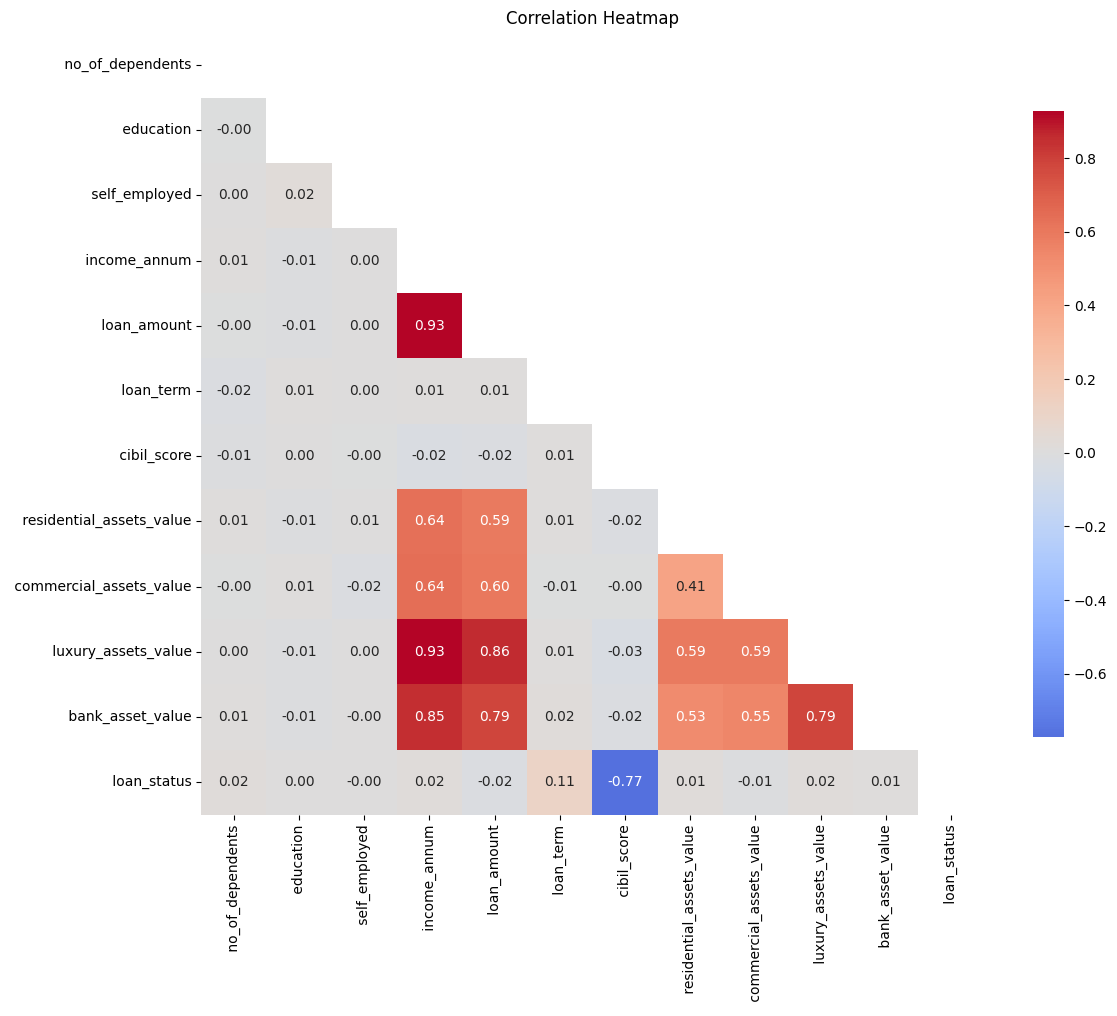

In [84]:
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix,
            mask=mask,           
            annot=True,          
            cmap='coolwarm',    
            center=0,            
            square=True,
            fmt='.2f',           
            cbar_kws={'shrink': 0.8})
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

##### Correlation Heatmap Analysis

The correlation heatmap reveals significant relationships among the variables in the loan prediction dataset. Income per annum shows a strong positive correlation with loan amount (0.93), luxury assets value (0.93), and bank asset value (0.85), indicating that higher income is closely tied to larger loans and asset values. Loan amount also exhibits strong correlations with luxury assets value (0.86) and bank asset value (0.79), reinforcing the financial linkage. Residential assets value correlates moderately with commercial assets value (0.64) and luxury assets value (0.64), while commercial assets value shows a moderate correlation with luxury assets value (0.59). Loan status has a notable negative correlation with cibil score (-0.77), suggesting that lower credit scores are associated with loan rejection. Other variables, such as the number of dependents, education, self-employment, and loan term, show weak correlations with most factors, with values close to zero.

In [85]:
numeric_cols = data.select_dtypes(include=['int64']).columns
skewness = data[numeric_cols].skew()
cols_to_log = skewness[abs(skewness) > 0.3].index
transformation_columns = [col for col in cols_to_log if col != 'loan_status']
print(f"Columns with skewness > 0.3: {cols_to_log.tolist()}" )

Columns with skewness > 0.3: [' loan_amount', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value']


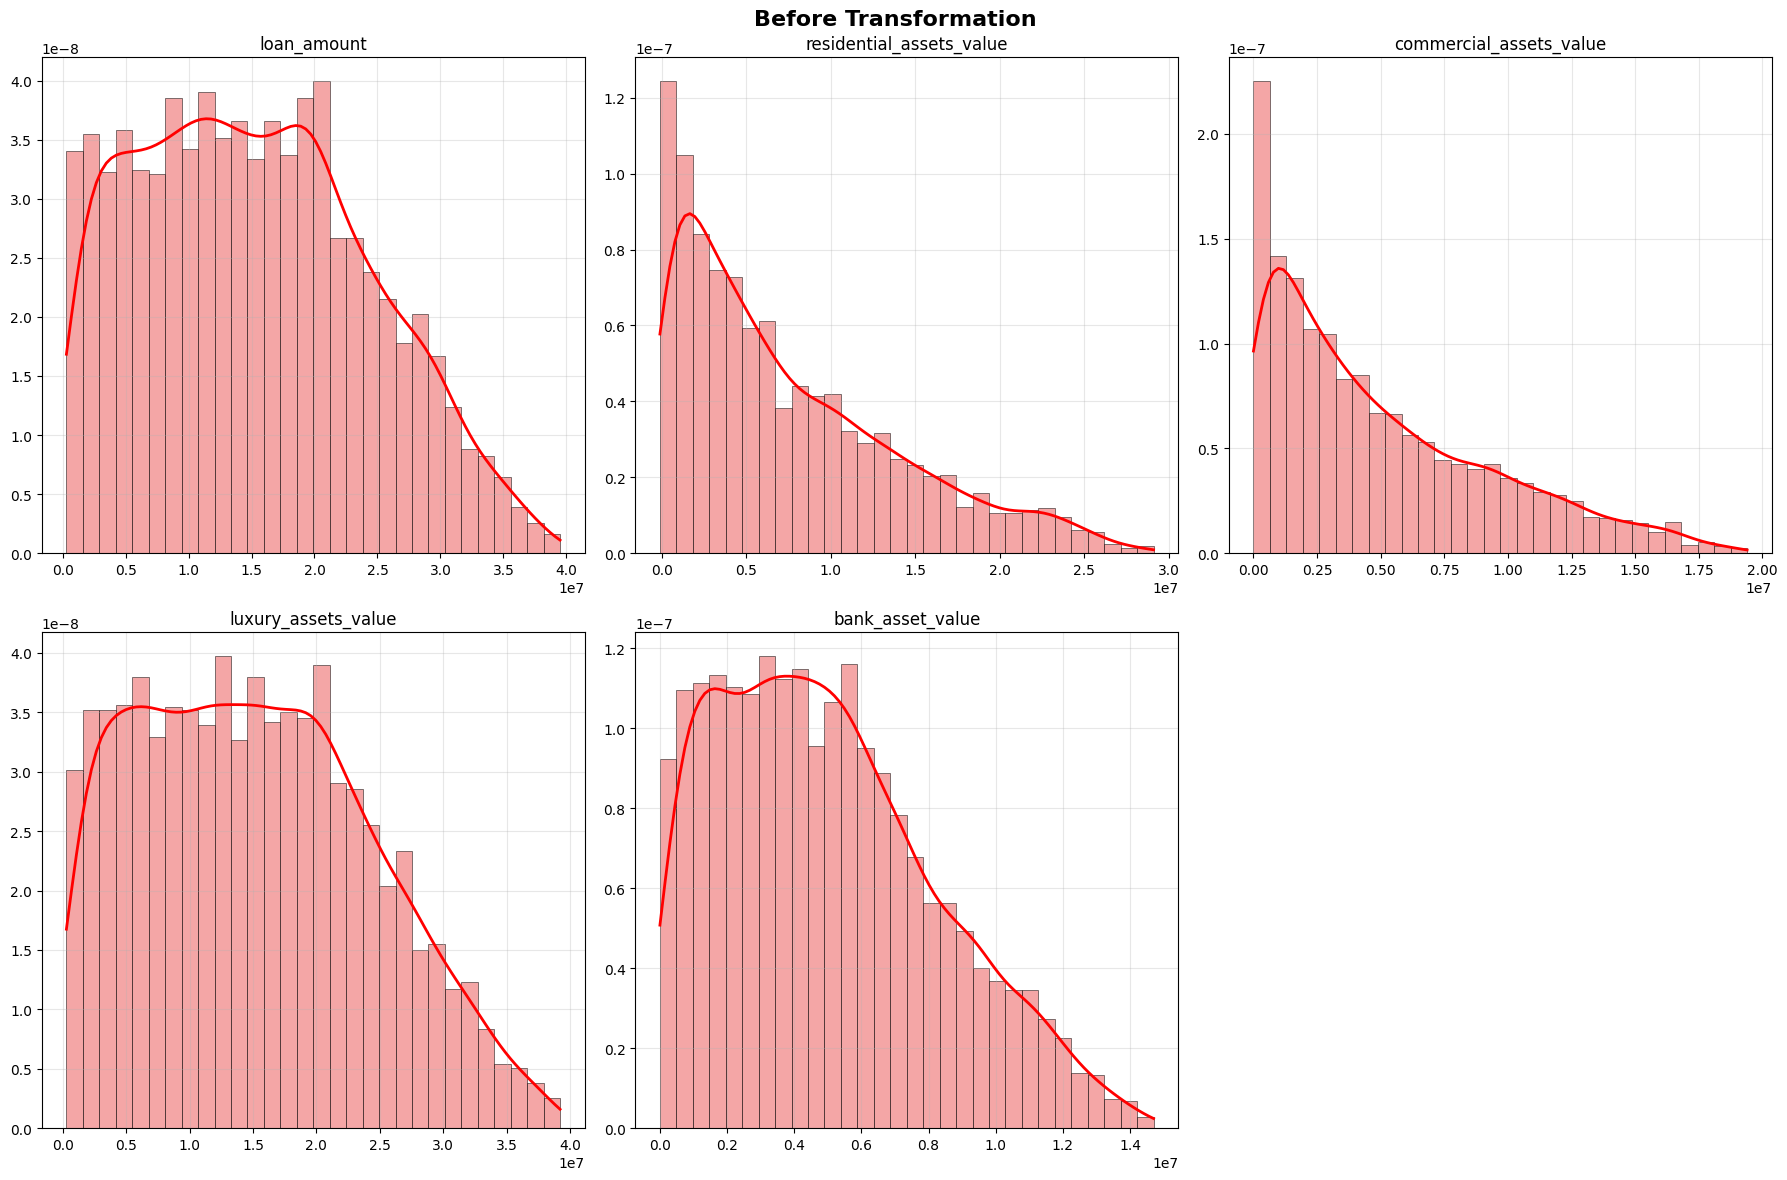

In [86]:
cols_to_transform = [' loan_amount', ' residential_assets_value', ' commercial_assets_value', 
                    ' luxury_assets_value', ' bank_asset_value']

n_cols = len(cols_to_transform)
num_rows = (n_cols + 2) // 3

fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6*num_rows))
fig.suptitle('Before Transformation', fontsize=16, fontweight='bold')

axes = axes.flatten() if n_cols > 1 else [axes]

for i, col in enumerate(cols_to_transform):
    if col in data.columns and i < len(axes):
        axes[i].hist(data[col], bins=30, alpha=0.7, color='lightcoral', 
                    density=True, edgecolor='black', linewidth=0.5)
        
        try:
            kde_x = np.linspace(data[col].min(), data[col].max(), 100)
            kde = stats.gaussian_kde(data[col])
            axes[i].plot(kde_x, kde(kde_x), color='red', linewidth=2)
        except:
            pass
            
        axes[i].set_title(f'{col.strip()}')
        axes[i].grid(True, alpha=0.3)

for i in range(n_cols, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [87]:
pt = PowerTransformer(method='yeo-johnson')
for col in cols_to_log:
    if col != 'loan_status':
        data[col] = pt.fit_transform(data[[col]].values)

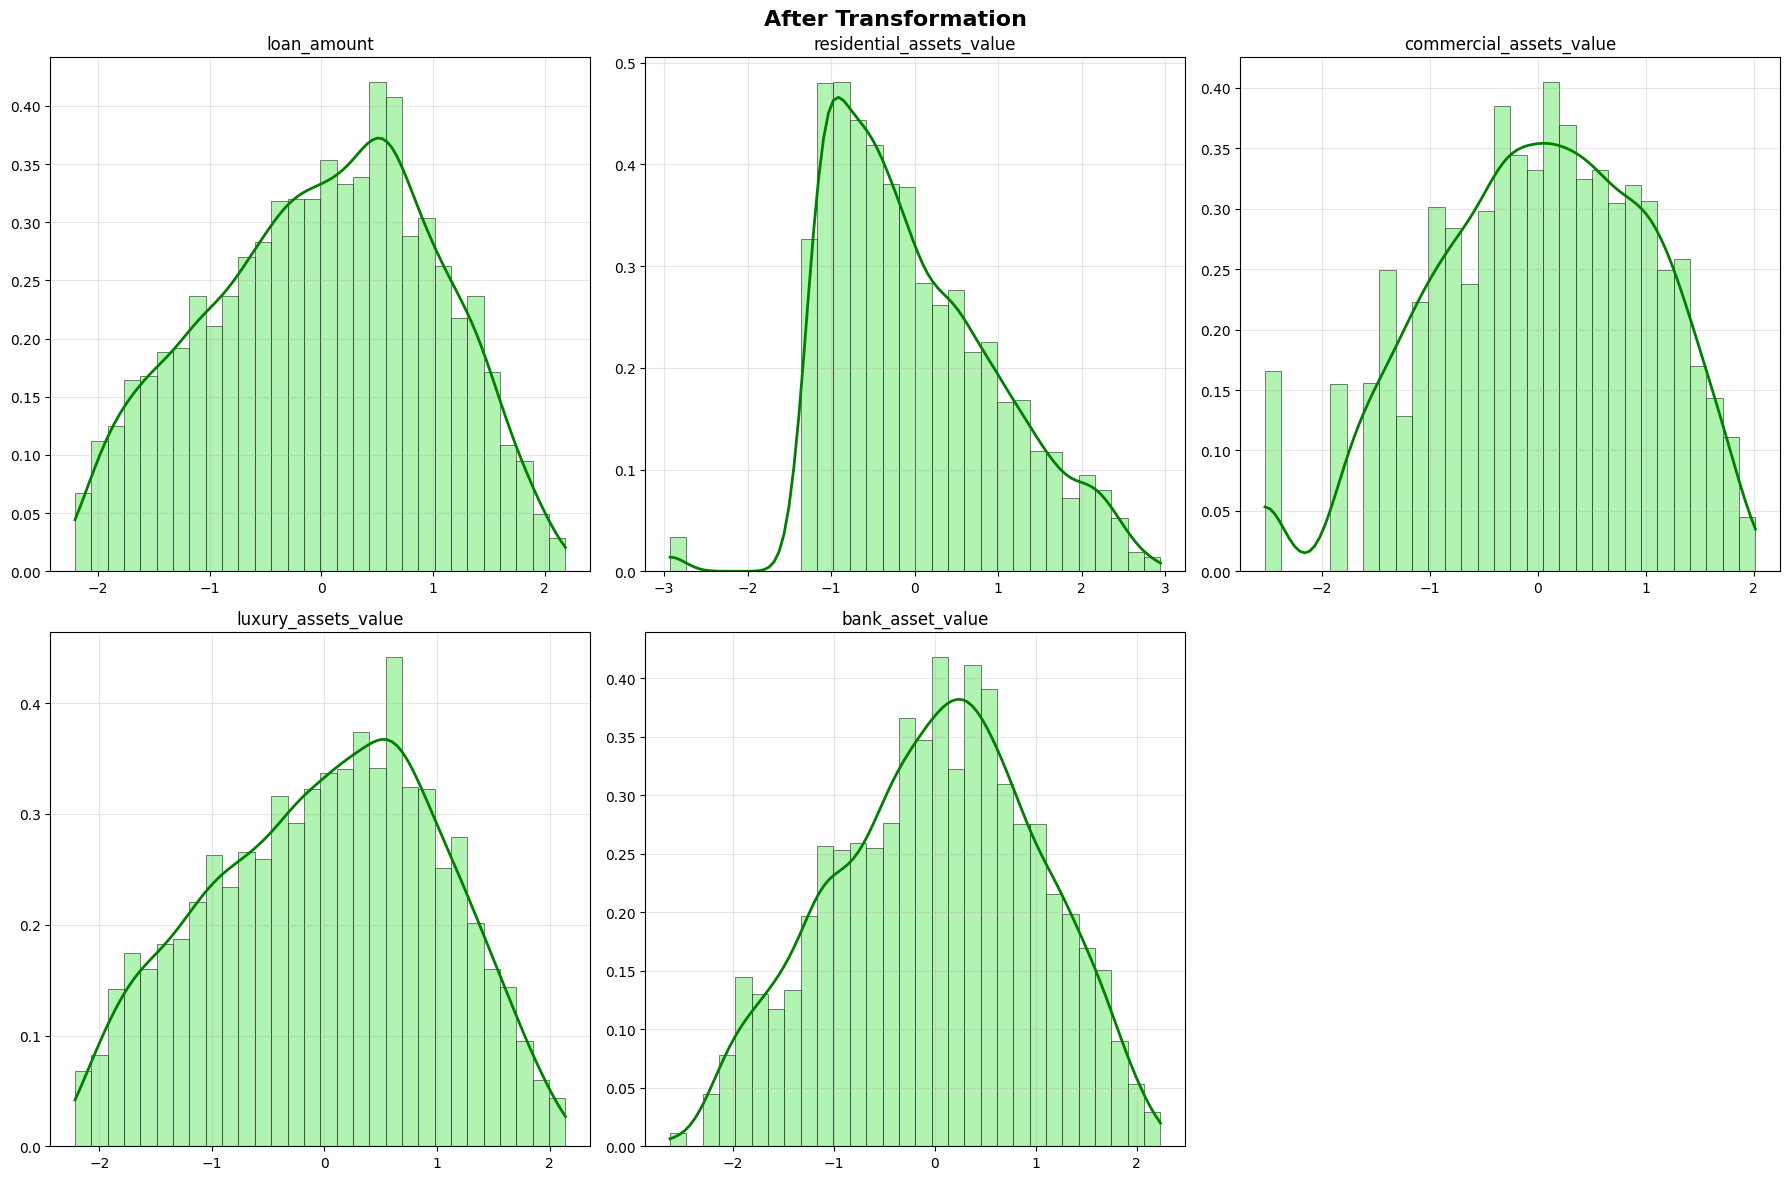

In [88]:
transformed_cols = [col for col in cols_to_transform]

fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6*num_rows))
fig.suptitle('After Transformation', fontsize=16, fontweight='bold')

axes = axes.flatten() if n_cols > 1 else [axes]

for i, col in enumerate(transformed_cols):
    if col in data.columns and i < len(axes):
        axes[i].hist(data[col], bins=30, alpha=0.7, color='lightgreen', 
                    density=True, edgecolor='black', linewidth=0.5)
        
        # Add KDE line
        try:
            kde_x = np.linspace(data[col].min(), data[col].max(), 100)
            kde = stats.gaussian_kde(data[col])
            axes[i].plot(kde_x, kde(kde_x), color='green', linewidth=2)
        except:
            pass
            
        axes[i].set_title(f'{col.strip()}')
        axes[i].grid(True, alpha=0.3)

for i in range(n_cols, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

##### Histogram Transformation Analysis

The histograms below show the distribution of variables before and after transformation. The transformation (likely logarithmic or normalization) shifts right-skewed distributions to more symmetric, bell-shaped ones.

| Variable              | Before Transformation         | After Transformation          | Difference                     |
|-----------------------|--------------------------------|--------------------------------|--------------------------------|
| Loan Amount           | Right-skewed, peak ~1.5e7     | Symmetric, peak ~0            | Skew reduced, centered at 0    |
| Residential Assets    | Right-skewed, peak ~0.5e7     | Symmetric, peak ~0            | Skew reduced, centered at 0    |
| Commercial Assets     | Right-skewed, peak ~0.5e7     | Symmetric, peak ~0            | Skew reduced, centered at 0    |
| Luxury Assets         | Right-skewed, peak ~1.5e7     | Symmetric, peak ~0            | Skew reduced, centered at 0    |
| Bank Asset Value      | Right-skewed, peak ~0.5e7     | Symmetric, peak ~0            | Skew reduced, centered at 0    |

**Key Observations:**
- **Before:** All variables exhibit right-skewed distributions with peaks at high values (e.g., 0.5e7 to 1.5e7), indicating a long tail of large values.
- **After:** Distributions are transformed into symmetric, bell-shaped curves centered around 0, suggesting normalization to improve statistical properties.
- **Transformation Impact:** The shift reduces skewness, likely aiding in variance stabilization and preparing data for modeling or analysis.

In [89]:
for col in numerical_columns:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col]
    percent_outliers = (outliers.count() / data[col].count()) * 100
    print(f"{col}: {percent_outliers:.2f}% outliers")

 no_of_dependents: 0.00% outliers
 income_annum: 0.00% outliers
 loan_amount: 0.00% outliers
 loan_term: 0.00% outliers
 cibil_score: 0.00% outliers
 residential_assets_value: 0.21% outliers
 commercial_assets_value: 0.00% outliers
 luxury_assets_value: 0.00% outliers
 bank_asset_value: 0.00% outliers


In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0    no_of_dependents          4269 non-null   int64  
 1    education                 4269 non-null   int32  
 2    self_employed             4269 non-null   int32  
 3    income_annum              4269 non-null   int64  
 4    loan_amount               4269 non-null   float64
 5    loan_term                 4269 non-null   int64  
 6    cibil_score               4269 non-null   int64  
 7    residential_assets_value  4269 non-null   float64
 8    commercial_assets_value   4269 non-null   float64
 9    luxury_assets_value       4269 non-null   float64
 10   bank_asset_value          4269 non-null   float64
 11   loan_status               4269 non-null   int32  
dtypes: float64(5), int32(3), int64(4)
memory usage: 350.3 KB


In [103]:
data[' loan_status'].value_counts()

 loan_status
0    2656
1    1613
Name: count, dtype: int64

---

## Feature selection analysis

---

In [91]:

def perform_feature_selection_analysis(data):
    # Correct column names with leading spaces
    numerical_features = [
        ' no_of_dependents', ' income_annum', ' loan_amount', ' loan_term', 
        ' cibil_score', ' residential_assets_value', ' commercial_assets_value',
        ' luxury_assets_value', ' bank_asset_value'
    ]
    
    categorical_features = [' education', ' self_employed']
    target = ' loan_status'
    
    results = {
        'feature': [], 'feature_type': [], 'anova_f_score': [], 'anova_p_value': [],
        'kendall_tau': [], 'kendall_p_value': [], 'chi2_score': [], 'chi2_p_value': [],
        'mutual_info_score': []
    }
    
    print("=== FEATURE SELECTION ANALYSIS ===\n")
    
    # Numerical Features Analysis
    X_numerical = data[numerical_features]
    y = data[target]
    f_scores, f_p_values = f_classif(X_numerical, y)
    
    print("NUMERICAL FEATURES - ANOVA F-test:")
    for i, feature in enumerate(numerical_features):
        tau, p_val = kendalltau(data[feature], y)
        mi_score = mutual_info_classif(data[[feature]], y, random_state=42)[0]
        
        print(f"{feature:30} | F: {f_scores[i]:8.4f} | p: {f_p_values[i]:.6f} | Tau: {tau:8.4f} | MI: {mi_score:8.4f}")
        
        results['feature'].append(feature)
        results['feature_type'].append('numerical')
        results['anova_f_score'].append(f_scores[i])
        results['anova_p_value'].append(f_p_values[i])
        results['kendall_tau'].append(abs(tau))
        results['kendall_p_value'].append(p_val)
        results['chi2_score'].append(np.nan)
        results['chi2_p_value'].append(np.nan)
        results['mutual_info_score'].append(mi_score)
    
    # Categorical Features Analysis
    print("\nCATEGORICAL FEATURES - Chi-square Test:")
    for feature in categorical_features:
        contingency_table = pd.crosstab(data[feature], y)
        chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
        mi_score = mutual_info_classif(data[[feature]], y, random_state=42)[0]
        
        print(f"{feature:30} | Chi2: {chi2_stat:8.4f} | p: {p_val:.6f} | MI: {mi_score:8.4f}")
        
        results['feature'].append(feature)
        results['feature_type'].append('categorical')
        results['anova_f_score'].append(np.nan)
        results['anova_p_value'].append(np.nan)
        results['kendall_tau'].append(np.nan)
        results['kendall_p_value'].append(np.nan)
        results['chi2_score'].append(chi2_stat)
        results['chi2_p_value'].append(p_val)
        results['mutual_info_score'].append(mi_score)
    
    # Create Rankings
    results_df = pd.DataFrame(results)
    rankings = pd.DataFrame({'feature': results_df['feature']})
    
    numerical_mask = results_df['feature_type'] == 'numerical'
    categorical_mask = results_df['feature_type'] == 'categorical'
    
    rankings['anova_rank'] = np.nan
    rankings.loc[numerical_mask, 'anova_rank'] = results_df.loc[numerical_mask, 'anova_f_score'].rank(ascending=False)
    
    rankings['kendall_rank'] = np.nan
    rankings.loc[numerical_mask, 'kendall_rank'] = results_df.loc[numerical_mask, 'kendall_tau'].rank(ascending=False)
    
    rankings['chi2_rank'] = np.nan
    rankings.loc[categorical_mask, 'chi2_rank'] = results_df.loc[categorical_mask, 'chi2_score'].rank(ascending=False)
    
    rankings['mi_rank'] = results_df['mutual_info_score'].rank(ascending=False)
    rankings['avg_rank'] = rankings[['anova_rank', 'kendall_rank', 'chi2_rank', 'mi_rank']].mean(axis=1, skipna=True)
    
    final_ranking = rankings.sort_values('avg_rank')
    
    print("\n=== FINAL FEATURE RANKING ===")
    print(f"{'Rank':<4} {'Feature':<30} {'Type':<12} {'MI Score':<10}")
    print("-" * 60)
    
    ranked_features = []
    for i, (idx, row) in enumerate(final_ranking.iterrows()):
        feature = row['feature']
        feature_type = results_df.loc[results_df['feature'] == feature, 'feature_type'].iloc[0]
        mi_score = results_df.loc[results_df['feature'] == feature, 'mutual_info_score'].iloc[0]
        
        print(f"{i+1:<4} {feature:<30} {feature_type:<12} {mi_score:<10.4f}")
        ranked_features.append(feature)
    
    return ranked_features, results_df

def create_feature_importance_plots(results_df, ranked_features):
    """Create comprehensive visualizations for feature importance"""
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Feature Importance Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Mutual Information Scores (All Features)
    ax1 = axes[0, 0]
    sorted_results = results_df.sort_values('mutual_info_score', ascending=True)
    colors = ['#3498db' if t == 'numerical' else '#e74c3c' for t in sorted_results['feature_type']]
    
    bars1 = ax1.barh(range(len(sorted_results)), sorted_results['mutual_info_score'], color=colors)
    ax1.set_yticks(range(len(sorted_results)))
    ax1.set_yticklabels([f.strip() for f in sorted_results['feature']], fontsize=9)
    ax1.set_xlabel('Mutual Information Score', fontweight='bold')
    ax1.set_title('Feature Importance - Mutual Information', fontweight='bold', pad=20)
    ax1.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars1):
        width = bar.get_width()
        ax1.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=8)
    
    # 2. ANOVA F-scores (Numerical features only)
    ax2 = axes[0, 1]
    numerical_results = results_df[results_df['feature_type'] == 'numerical'].sort_values('anova_f_score', ascending=True)
    
    if len(numerical_results) > 0:
        bars2 = ax2.barh(range(len(numerical_results)), numerical_results['anova_f_score'], color='#3498db')
        ax2.set_yticks(range(len(numerical_results)))
        ax2.set_yticklabels([f.strip() for f in numerical_results['feature']], fontsize=9)
        ax2.set_xlabel('ANOVA F-Score', fontweight='bold')
        ax2.set_title('Numerical Features - ANOVA F-Test', fontweight='bold', pad=20)
        ax2.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, bar in enumerate(bars2):
            width = bar.get_width()
            ax2.text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
                    f'{width:.1f}', ha='left', va='center', fontsize=8)
    
    # 3. Chi-square scores (Categorical features only)
    ax3 = axes[1, 0]
    categorical_results = results_df[results_df['feature_type'] == 'categorical'].sort_values('chi2_score', ascending=True)
    
    if len(categorical_results) > 0:
        bars3 = ax3.barh(range(len(categorical_results)), categorical_results['chi2_score'], color='#e74c3c')
        ax3.set_yticks(range(len(categorical_results)))
        ax3.set_yticklabels([f.strip() for f in categorical_results['feature']], fontsize=9)
        ax3.set_xlabel('Chi-square Score', fontweight='bold')
        ax3.set_title('Categorical Features - Chi-square Test', fontweight='bold', pad=20)
        ax3.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, bar in enumerate(bars3):
            width = bar.get_width()
            ax3.text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
                    f'{width:.1f}', ha='left', va='center', fontsize=8)
    
    # 4. Final Ranking (Top 10)
    ax4 = axes[1, 1]
    top_10_features = ranked_features[:10]
    top_10_results = results_df[results_df['feature'].isin(top_10_features)]
    top_10_results = top_10_results.set_index('feature').reindex(top_10_features).reset_index()
    
    colors = ['#3498db' if t == 'numerical' else '#e74c3c' for t in top_10_results['feature_type']]
    
    bars4 = ax4.barh(range(len(top_10_results)), 
                     [i+1 for i in range(len(top_10_results))], color=colors)
    ax4.set_yticks(range(len(top_10_results)))
    ax4.set_yticklabels([f.strip() for f in top_10_results['feature']], fontsize=9)
    ax4.set_xlabel('Rank (1 = Most Important)', fontweight='bold')
    ax4.set_title('Top 10 Features - Final Ranking', fontweight='bold', pad=20)
    ax4.grid(axis='x', alpha=0.3)
    ax4.invert_xaxis()
    
    # Add rank labels
    for i, bar in enumerate(bars4):
        width = bar.get_width()
        ax4.text(width - 0.1, bar.get_y() + bar.get_height()/2, 
                f'#{i+1}', ha='center', va='center', fontweight='bold', fontsize=8)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#3498db', label='Numerical'),
                      Patch(facecolor='#e74c3c', label='Categorical')]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))
    
    plt.tight_layout()
    plt.show()
    
    # Create a second plot - Feature Comparison Heatmap
    create_feature_comparison_heatmap(results_df)
    
    return fig

def create_feature_comparison_heatmap(results_df):
    """Create a heatmap comparing different statistical measures"""
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Prepare data for heatmap
    heatmap_data = results_df[['feature', 'anova_f_score', 'kendall_tau', 'chi2_score', 'mutual_info_score']].copy()
    heatmap_data['feature'] = heatmap_data['feature'].str.strip()
    heatmap_data = heatmap_data.set_index('feature')
    
    # Normalize scores to 0-1 range for better comparison
    for col in heatmap_data.columns:
        if heatmap_data[col].notna().any():
            max_val = heatmap_data[col].max()
            if max_val > 0:
                heatmap_data[col] = heatmap_data[col] / max_val
    
    # Create heatmap
    sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='RdYlBu_r', 
                cbar_kws={'label': 'Normalized Score'}, ax=ax)
    
    ax.set_title('Feature Importance Comparison - Normalized Scores', fontweight='bold', pad=20)
    ax.set_xlabel('Features', fontweight='bold')
    ax.set_ylabel('Statistical Tests', fontweight='bold')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return fig

def get_top_features(ranked_features, n_features):
    """Get top n features for model training"""
    return ranked_features[:n_features]

def print_feature_selection(ranked_features, n_features):
    """Print selected features for easy copying"""
    selected = get_top_features(ranked_features, n_features)
    print(f"\n=== TOP {n_features} FEATURES FOR TRAINING ===")
    print("Selected features:")
    for i, feature in enumerate(selected, 1):
        print(f"{i}. {feature}")
    
    print(f"\nFeatures list for code:")
    print(f"features = {selected}")
    return selected


=== FEATURE SELECTION ANALYSIS ===

NUMERICAL FEATURES - ANOVA F-test:
 no_of_dependents              | F:   1.4006 | p: 0.236689 | Tau:   0.0160 | MI:   0.0016
 income_annum                  | F:   0.9847 | p: 0.321105 | Tau:   0.0124 | MI:   0.0152
 loan_amount                   | F:   0.4041 | p: 0.525023 | Tau:  -0.0103 | MI:   0.0040
 loan_term                     | F:  55.2255 | p: 0.000000 | Tau:   0.0983 | MI:   0.0207
 cibil_score                   | F: 6235.0546 | p: 0.000000 | Tau:  -0.6307 | MI:   0.5044
 residential_assets_value      | F:   0.7688 | p: 0.380634 | Tau:   0.0134 | MI:   0.0000
 commercial_assets_value       | F:   0.3542 | p: 0.551804 | Tau:  -0.0074 | MI:   0.0080
 luxury_assets_value           | F:   1.3716 | p: 0.241600 | Tau:   0.0141 | MI:   0.0018
 bank_asset_value              | F:   0.5638 | p: 0.452778 | Tau:   0.0082 | MI:   0.0131

CATEGORICAL FEATURES - Chi-square Test:
 education                     | Chi2:   0.0840 | p: 0.772004 | MI:   0.0000


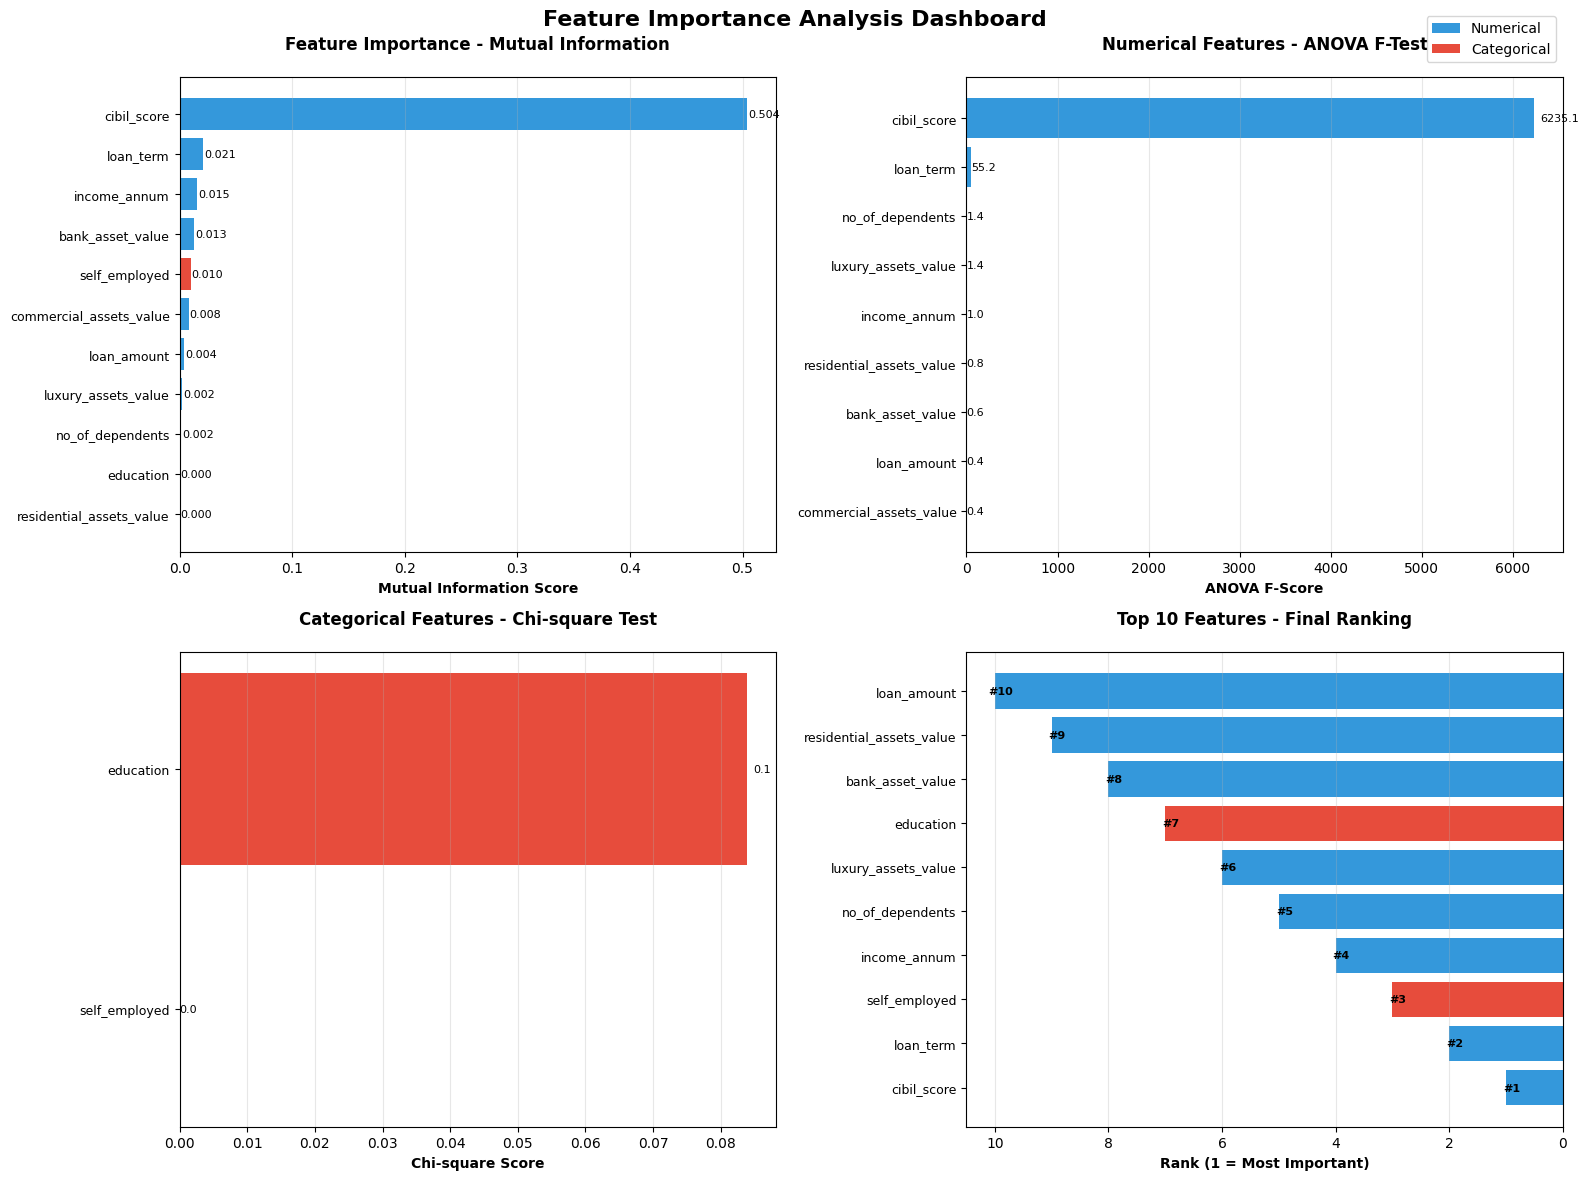

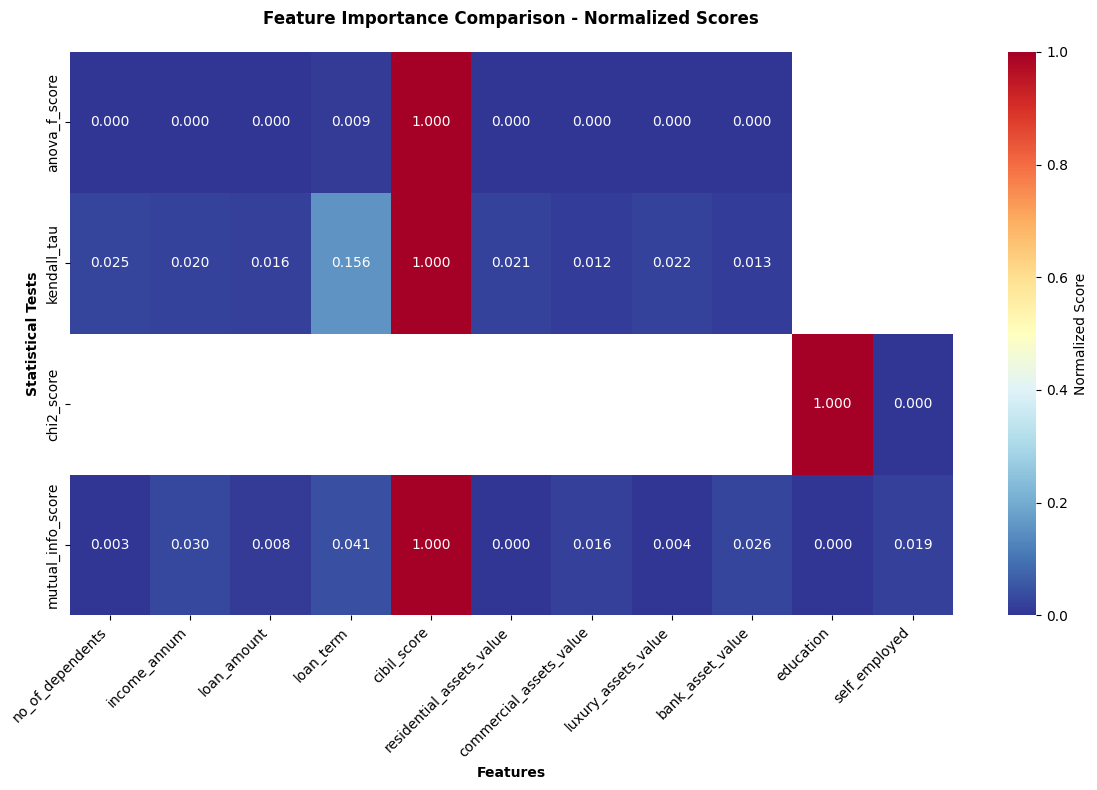


=== TOP 12 FEATURES FOR TRAINING ===
Selected features:
1.  cibil_score
2.  loan_term
3.  self_employed
4.  income_annum
5.  no_of_dependents
6.  luxury_assets_value
7.  education
8.  bank_asset_value
9.  residential_assets_value
10.  loan_amount
11.  commercial_assets_value

Features list for code:
features = [' cibil_score', ' loan_term', ' self_employed', ' income_annum', ' no_of_dependents', ' luxury_assets_value', ' education', ' bank_asset_value', ' residential_assets_value', ' loan_amount', ' commercial_assets_value']


In [92]:
ranked_features, results_df = perform_feature_selection_analysis(data)

create_feature_importance_plots(results_df, ranked_features)

top_features = print_feature_selection(ranked_features, 12)


##### Feature Selection Analysis

| Feature                | Type         | ANOVA F-Score | p-value   | Tau       | MI Score  | Chi2 Score | Final Rank |
|-----------------------|--------------|---------------|-----------|-----------|-----------|------------|------------|
| cibil_score           | Numerical    | 6235.0546     | 0.000000  | -0.6307   | 0.5044    | -          | 1          |
| loan_term             | Numerical    | 55.2255       | 0.000000  | 0.0983    | 0.0207    | -          | 2          |
| self_employed         | Categorical  | -             | -         | -         | 0.0097    | 0.0000     | 3          |
| income_annum          | Numerical    | 0.9847        | 0.321105  | 0.0124    | 0.0152    | -          | 4          |
| no_of_dependents      | Numerical    | 1.4006        | 0.236689  | 0.0160    | 0.0016    | -          | 5          |
| luxury_assets_value   | Numerical    | 1.3716        | 0.241600  | 0.0141    | 0.0018    | -          | 6          |
| education             | Categorical  | -             | -         | -         | 0.0000    | 0.0840     | 7          |
| bank_asset_value      | Numerical    | 0.5638        | 0.452778  | 0.0082    | 0.0131    | -          | 8          |
| residential_assets_value | Numerical | 0.7688     | 0.380634  | 0.0134    | 0.0000    | -          | 9          |
| loan_amount           | Numerical    | 0.4041        | 0.525023  | -0.0103   | 0.0040    | -          | 10         |
| commercial_assets_value | Numerical | 0.3542    | 0.551804  | -0.0074   | 0.0080    | -          | 11         |

**Top 12 Features for Training:**
- Selected features: cibil_score, loan_term, self_employed, income_annum, no_of_dependents, luxury_assets_value, education, bank_asset_value, residential_assets_value, loan_amount, commercial_assets_value
- Features list for code: `features = ['cibil_score', 'loan_term', 'self_employed', 'income_annum', 'no_of_dependents', 'luxury_assets_value', 'education', 'bank_asset_value', 'residential_assets_value', 'loan_amount', 'commercial_assets_value']`

**Notes:**
- Cibil score and loan term dominate with high F-scores and MI, indicating strong predictive power.
- Education shows moderate Chi2 significance despite low MI.
- Transformation aligns with dashboard rankings, emphasizing cibil_score's top importance.

---
## Model Building and Evaluation
Train and test machine learning models and evaluate model performance using appropriate metrics..

---

In [93]:
X = data[top_features]
y = data[' loan_status']
X_train_regular, X_test, y_train_regular, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

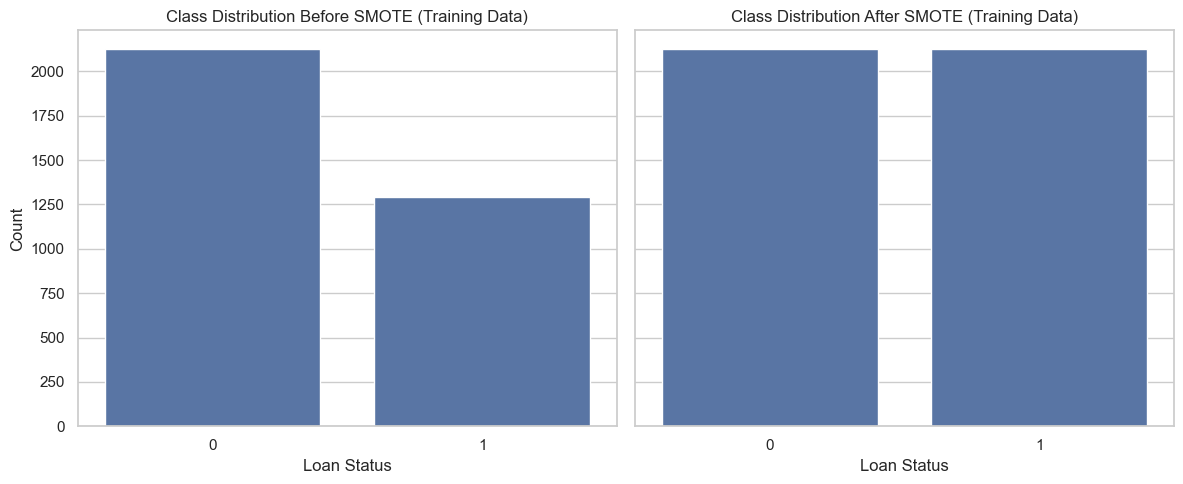

Regular Training set shape: (3415, 11) (3415,)
SMOTE Training set shape: (4250, 11) (4250,)
Testing set shape: (854, 11) (854,)


In [94]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_regular, y_train_regular)

sns.set(style="whitegrid")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.countplot(x=y_train_regular, ax=ax1)
ax1.set_title('Class Distribution Before SMOTE (Training Data)')
ax1.set_xlabel('Loan Status')
ax1.set_ylabel('Count')

sns.countplot(x=y_train_smote, ax=ax2)
ax2.set_title('Class Distribution After SMOTE (Training Data)')
ax2.set_xlabel('Loan Status')

plt.tight_layout()
plt.show()


print("Regular Training set shape:", X_train_regular.shape, y_train_regular.shape)
print("SMOTE Training set shape:", X_train_smote.shape, y_train_smote.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

In [95]:
scaler = StandardScaler()
scaler.fit(X_train_regular)

X_train_regular_scaled = scaler.transform(X_train_regular)
X_train_smote_scaled = scaler.transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

X_train_regular_scaled = pd.DataFrame(X_train_regular_scaled, columns=X_train_regular.columns)
X_train_smote_scaled = pd.DataFrame(X_train_smote_scaled, columns=X_train_regular.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [96]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'Logistic Regression': LogisticRegression(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0)
}

# Initialize results storage
results = []

# Function to evaluate and plot for a single model
def evaluate_model(model_name, model, X_train, y_train, X_test, y_test, dataset_type):
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    gap = train_acc - test_acc
    precision = precision_score(y_test, y_test_pred, average='binary')
    recall = recall_score(y_test, y_test_pred, average='binary')
    f1 = f1_score(y_test, y_test_pred, average='binary')
    
    # Store results
    results.append({
        'Model': model_name,
        'Dataset': dataset_type,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Train-Test Gap': gap,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })
    
    print(f"\n{model_name} ({dataset_type})")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Train-Test Gap: {gap:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: {model_name} ({dataset_type})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Decision Tree (Regular)
CV Accuracy: 0.9780
Test Accuracy: 0.9766
CV-Test Gap: 0.0015
Precision: 0.9779
Recall: 0.9598
F1-Score: 0.9688


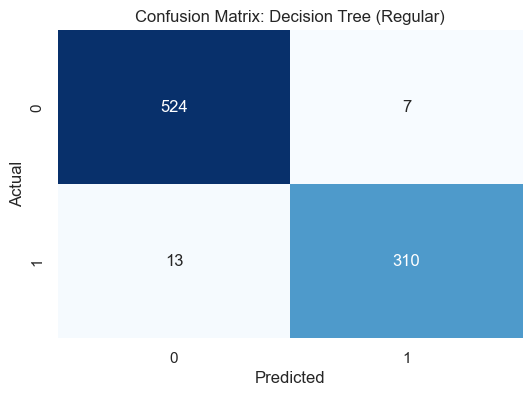

Decision Tree (SMOTE)
CV Accuracy: 0.9772
Test Accuracy: 0.9754
CV-Test Gap: 0.0018
Precision: 0.9778
Recall: 0.9567
F1-Score: 0.9671


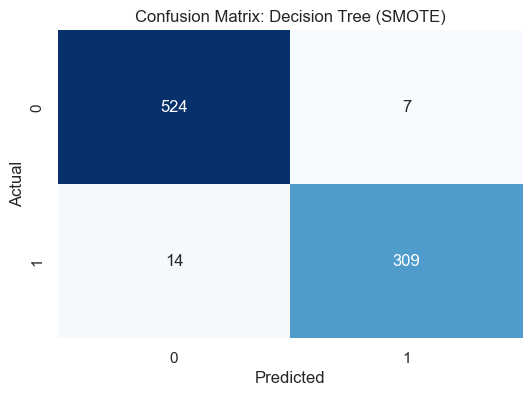

In [97]:

model = DecisionTreeClassifier(random_state=42)

# Regular dataset
cv_scores = cross_val_score(model, X_train_regular_scaled, y_train_regular, cv=5, scoring='accuracy')
model.fit(X_train_regular_scaled, y_train_regular)
y_test_pred = model.predict(X_test_scaled)
cv_acc = cv_scores.mean()
test_acc = accuracy_score(y_test, y_test_pred)
results.append({
    'Model': 'Decision Tree', 'Dataset': 'Regular',
    'CV Accuracy': cv_acc, 'Test Accuracy': test_acc, 'CV-Test Gap': cv_acc - test_acc,
    'Precision': precision_score(y_test, y_test_pred, average='binary'),
    'Recall': recall_score(y_test, y_test_pred, average='binary'),
    'F1-Score': f1_score(y_test, y_test_pred, average='binary')
})
print(f"Decision Tree (Regular)\nCV Accuracy: {cv_acc:.4f}\nTest Accuracy: {test_acc:.4f}\nCV-Test Gap: {cv_acc - test_acc:.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, average='binary'):.4f}\nRecall: {recall_score(y_test, y_test_pred, average='binary'):.4f}\nF1-Score: {f1_score(y_test, y_test_pred, average='binary'):.4f}")
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Decision Tree (Regular)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# SMOTE dataset
cv_scores = cross_val_score(model, X_train_smote_scaled, y_train_smote, cv=5, scoring='accuracy')
model.fit(X_train_smote_scaled, y_train_smote)
y_test_pred = model.predict(X_test_scaled)
cv_acc = cv_scores.mean()
test_acc = accuracy_score(y_test, y_test_pred)
results.append({
    'Model': 'Decision Tree', 'Dataset': 'SMOTE',
    'CV Accuracy': cv_acc, 'Test Accuracy': test_acc, 'CV-Test Gap': cv_acc - test_acc,
    'Precision': precision_score(y_test, y_test_pred, average='binary'),
    'Recall': recall_score(y_test, y_test_pred, average='binary'),
    'F1-Score': f1_score(y_test, y_test_pred, average='binary')
})
print(f"Decision Tree (SMOTE)\nCV Accuracy: {cv_acc:.4f}\nTest Accuracy: {test_acc:.4f}\nCV-Test Gap: {cv_acc - test_acc:.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, average='binary'):.4f}\nRecall: {recall_score(y_test, y_test_pred, average='binary'):.4f}\nF1-Score: {f1_score(y_test, y_test_pred, average='binary'):.4f}")
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Decision Tree (SMOTE)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Random Forest (Regular)
CV Accuracy: 0.9795
Test Accuracy: 0.9836
CV-Test Gap: -0.0041
Precision: 0.9936
Recall: 0.9628
F1-Score: 0.9780


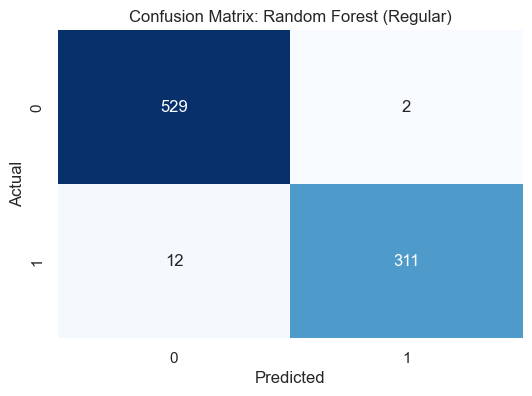

Random Forest (SMOTE)
CV Accuracy: 0.9807
Test Accuracy: 0.9836
CV-Test Gap: -0.0029
Precision: 0.9874
Recall: 0.9690
F1-Score: 0.9781


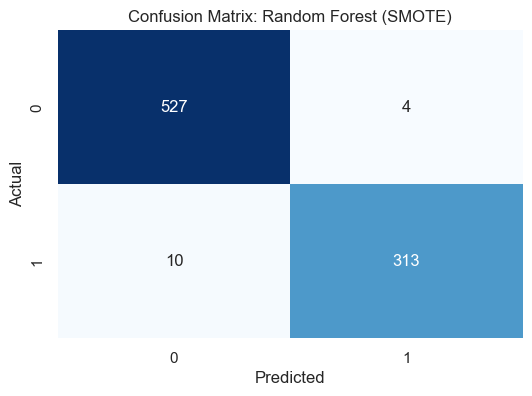

In [98]:
model = RandomForestClassifier(random_state=42)

# Regular dataset
cv_scores = cross_val_score(model, X_train_regular_scaled, y_train_regular, cv=5, scoring='accuracy')
model.fit(X_train_regular_scaled, y_train_regular)
y_test_pred = model.predict(X_test_scaled)
cv_acc = cv_scores.mean()
test_acc = accuracy_score(y_test, y_test_pred)
results.append({
    'Model': 'Random Forest', 'Dataset': 'Regular',
    'CV Accuracy': cv_acc, 'Test Accuracy': test_acc, 'CV-Test Gap': cv_acc - test_acc,
    'Precision': precision_score(y_test, y_test_pred, average='binary'),
    'Recall': recall_score(y_test, y_test_pred, average='binary'),
    'F1-Score': f1_score(y_test, y_test_pred, average='binary')
})
print(f"Random Forest (Regular)\nCV Accuracy: {cv_acc:.4f}\nTest Accuracy: {test_acc:.4f}\nCV-Test Gap: {cv_acc - test_acc:.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, average='binary'):.4f}\nRecall: {recall_score(y_test, y_test_pred, average='binary'):.4f}\nF1-Score: {f1_score(y_test, y_test_pred, average='binary'):.4f}")
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Random Forest (Regular)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# SMOTE dataset
cv_scores = cross_val_score(model, X_train_smote_scaled, y_train_smote, cv=5, scoring='accuracy')
model.fit(X_train_smote_scaled, y_train_smote)
y_test_pred = model.predict(X_test_scaled)
cv_acc = cv_scores.mean()
test_acc = accuracy_score(y_test, y_test_pred)
results.append({
    'Model': 'Random Forest', 'Dataset': 'SMOTE',
    'CV Accuracy': cv_acc, 'Test Accuracy': test_acc, 'CV-Test Gap': cv_acc - test_acc,
    'Precision': precision_score(y_test, y_test_pred, average='binary'),
    'Recall': recall_score(y_test, y_test_pred, average='binary'),
    'F1-Score': f1_score(y_test, y_test_pred, average='binary')
})
print(f"Random Forest (SMOTE)\nCV Accuracy: {cv_acc:.4f}\nTest Accuracy: {test_acc:.4f}\nCV-Test Gap: {cv_acc - test_acc:.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, average='binary'):.4f}\nRecall: {recall_score(y_test, y_test_pred, average='binary'):.4f}\nF1-Score: {f1_score(y_test, y_test_pred, average='binary'):.4f}")
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Random Forest (SMOTE)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

LightGBM (Regular)
CV Accuracy: 0.9842
Test Accuracy: 0.9859
CV-Test Gap: -0.0018
Precision: 0.9937
Recall: 0.9690
F1-Score: 0.9812


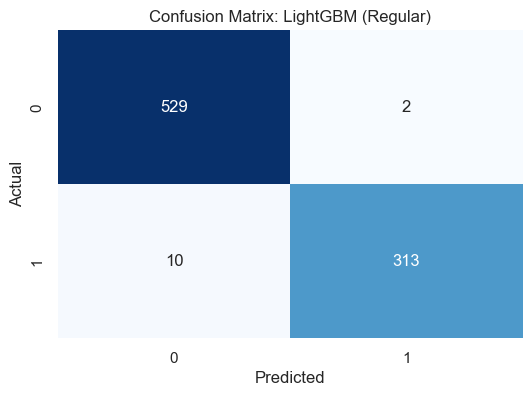

LightGBM (SMOTE)
CV Accuracy: 0.9849
Test Accuracy: 0.9871
CV-Test Gap: -0.0022
Precision: 0.9937
Recall: 0.9721
F1-Score: 0.9828


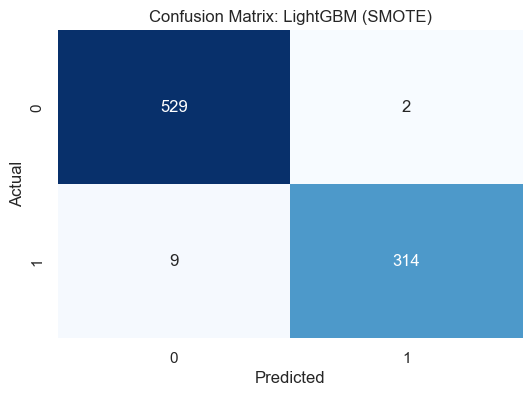

In [99]:
model = LGBMClassifier(random_state=42, verbose=-1)

# Regular dataset
cv_scores = cross_val_score(model, X_train_regular_scaled, y_train_regular, cv=5, scoring='accuracy')
model.fit(X_train_regular_scaled, y_train_regular)
y_test_pred = model.predict(X_test_scaled)
cv_acc = cv_scores.mean()
test_acc = accuracy_score(y_test, y_test_pred)
results.append({
    'Model': 'LightGBM', 'Dataset': 'Regular',
    'CV Accuracy': cv_acc, 'Test Accuracy': test_acc, 'CV-Test Gap': cv_acc - test_acc,
    'Precision': precision_score(y_test, y_test_pred, average='binary'),
    'Recall': recall_score(y_test, y_test_pred, average='binary'),
    'F1-Score': f1_score(y_test, y_test_pred, average='binary')
})
print(f"LightGBM (Regular)\nCV Accuracy: {cv_acc:.4f}\nTest Accuracy: {test_acc:.4f}\nCV-Test Gap: {cv_acc - test_acc:.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, average='binary'):.4f}\nRecall: {recall_score(y_test, y_test_pred, average='binary'):.4f}\nF1-Score: {f1_score(y_test, y_test_pred, average='binary'):.4f}")
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: LightGBM (Regular)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# SMOTE dataset
cv_scores = cross_val_score(model, X_train_smote_scaled, y_train_smote, cv=5, scoring='accuracy')
model.fit(X_train_smote_scaled, y_train_smote)
y_test_pred = model.predict(X_test_scaled)
cv_acc = cv_scores.mean()
test_acc = accuracy_score(y_test, y_test_pred)
results.append({
    'Model': 'LightGBM', 'Dataset': 'SMOTE',
    'CV Accuracy': cv_acc, 'Test Accuracy': test_acc, 'CV-Test Gap': cv_acc - test_acc,
    'Precision': precision_score(y_test, y_test_pred, average='binary'),
    'Recall': recall_score(y_test, y_test_pred, average='binary'),
    'F1-Score': f1_score(y_test, y_test_pred, average='binary')
})
print(f"LightGBM (SMOTE)\nCV Accuracy: {cv_acc:.4f}\nTest Accuracy: {test_acc:.4f}\nCV-Test Gap: {cv_acc - test_acc:.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, average='binary'):.4f}\nRecall: {recall_score(y_test, y_test_pred, average='binary'):.4f}\nF1-Score: {f1_score(y_test, y_test_pred, average='binary'):.4f}")
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: LightGBM (SMOTE)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Logistic Regression (Regular)
CV Accuracy: 0.9089
Test Accuracy: 0.9215
CV-Test Gap: -0.0126
Precision: 0.9238
Recall: 0.8638
F1-Score: 0.8928


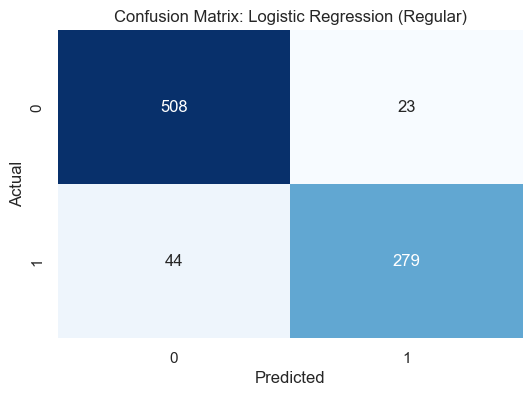

Logistic Regression (SMOTE)
CV Accuracy: 0.9242
Test Accuracy: 0.9321
CV-Test Gap: -0.0078
Precision: 0.9154
Recall: 0.9040
F1-Score: 0.9097


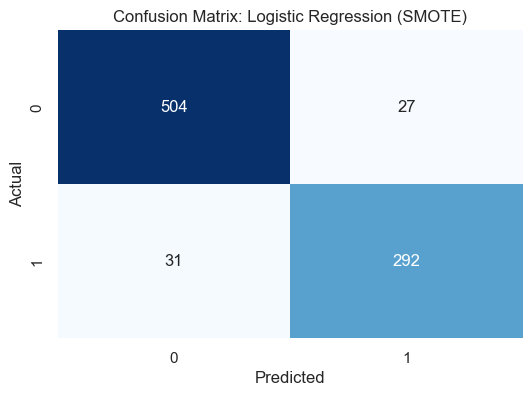

In [100]:
model = LogisticRegression(random_state=42)

# Regular dataset
cv_scores = cross_val_score(model, X_train_regular_scaled, y_train_regular, cv=5, scoring='accuracy')
model.fit(X_train_regular_scaled, y_train_regular)
y_test_pred = model.predict(X_test_scaled)
cv_acc = cv_scores.mean()
test_acc = accuracy_score(y_test, y_test_pred)
results.append({
    'Model': 'Logistic Regression', 'Dataset': 'Regular',
    'CV Accuracy': cv_acc, 'Test Accuracy': test_acc, 'CV-Test Gap': cv_acc - test_acc,
    'Precision': precision_score(y_test, y_test_pred, average='binary'),
    'Recall': recall_score(y_test, y_test_pred, average='binary'),
    'F1-Score': f1_score(y_test, y_test_pred, average='binary')
})
print(f"Logistic Regression (Regular)\nCV Accuracy: {cv_acc:.4f}\nTest Accuracy: {test_acc:.4f}\nCV-Test Gap: {cv_acc - test_acc:.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, average='binary'):.4f}\nRecall: {recall_score(y_test, y_test_pred, average='binary'):.4f}\nF1-Score: {f1_score(y_test, y_test_pred, average='binary'):.4f}")
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Logistic Regression (Regular)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# SMOTE dataset
cv_scores = cross_val_score(model, X_train_smote_scaled, y_train_smote, cv=5, scoring='accuracy')
model.fit(X_train_smote_scaled, y_train_smote)
y_test_pred = model.predict(X_test_scaled)
cv_acc = cv_scores.mean()
test_acc = accuracy_score(y_test, y_test_pred)
results.append({
    'Model': 'Logistic Regression', 'Dataset': 'SMOTE',
    'CV Accuracy': cv_acc, 'Test Accuracy': test_acc, 'CV-Test Gap': cv_acc - test_acc,
    'Precision': precision_score(y_test, y_test_pred, average='binary'),
    'Recall': recall_score(y_test, y_test_pred, average='binary'),
    'F1-Score': f1_score(y_test, y_test_pred, average='binary')
})
print(f"Logistic Regression (SMOTE)\nCV Accuracy: {cv_acc:.4f}\nTest Accuracy: {test_acc:.4f}\nCV-Test Gap: {cv_acc - test_acc:.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, average='binary'):.4f}\nRecall: {recall_score(y_test, y_test_pred, average='binary'):.4f}\nF1-Score: {f1_score(y_test, y_test_pred, average='binary'):.4f}")
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Logistic Regression (SMOTE)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

CatBoost (Regular)
CV Accuracy: 0.9827
Test Accuracy: 0.9813
CV-Test Gap: 0.0015
Precision: 0.9904
Recall: 0.9598
F1-Score: 0.9748


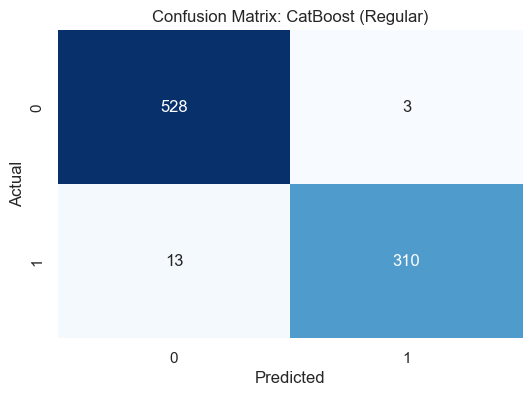

CatBoost (SMOTE)
CV Accuracy: 0.9854
Test Accuracy: 0.9836
CV-Test Gap: 0.0018
Precision: 0.9905
Recall: 0.9659
F1-Score: 0.9781


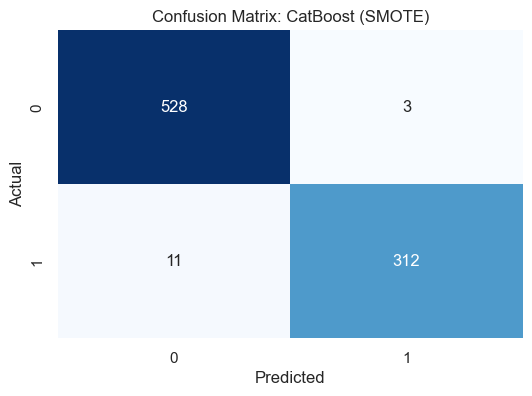

In [101]:
model = CatBoostClassifier(random_state=42, verbose=0)

# Regular dataset
cv_scores = cross_val_score(model, X_train_regular_scaled, y_train_regular, cv=5, scoring='accuracy')
model.fit(X_train_regular_scaled, y_train_regular)
y_test_pred = model.predict(X_test_scaled)
cv_acc = cv_scores.mean()
test_acc = accuracy_score(y_test, y_test_pred)
results.append({
    'Model': 'CatBoost', 'Dataset': 'Regular',
    'CV Accuracy': cv_acc, 'Test Accuracy': test_acc, 'CV-Test Gap': cv_acc - test_acc,
    'Precision': precision_score(y_test, y_test_pred, average='binary'),
    'Recall': recall_score(y_test, y_test_pred, average='binary'),
    'F1-Score': f1_score(y_test, y_test_pred, average='binary')
})
print(f"CatBoost (Regular)\nCV Accuracy: {cv_acc:.4f}\nTest Accuracy: {test_acc:.4f}\nCV-Test Gap: {cv_acc - test_acc:.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, average='binary'):.4f}\nRecall: {recall_score(y_test, y_test_pred, average='binary'):.4f}\nF1-Score: {f1_score(y_test, y_test_pred, average='binary'):.4f}")
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: CatBoost (Regular)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# SMOTE dataset
cv_scores = cross_val_score(model, X_train_smote_scaled, y_train_smote, cv=5, scoring='accuracy')
model.fit(X_train_smote_scaled, y_train_smote)
y_test_pred = model.predict(X_test_scaled)
cv_acc = cv_scores.mean()
test_acc = accuracy_score(y_test, y_test_pred)
results.append({
    'Model': 'CatBoost', 'Dataset': 'SMOTE',
    'CV Accuracy': cv_acc, 'Test Accuracy': test_acc, 'CV-Test Gap': cv_acc - test_acc,
    'Precision': precision_score(y_test, y_test_pred, average='binary'),
    'Recall': recall_score(y_test, y_test_pred, average='binary'),
    'F1-Score': f1_score(y_test, y_test_pred, average='binary')
})
print(f"CatBoost (SMOTE)\nCV Accuracy: {cv_acc:.4f}\nTest Accuracy: {test_acc:.4f}\nCV-Test Gap: {cv_acc - test_acc:.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, average='binary'):.4f}\nRecall: {recall_score(y_test, y_test_pred, average='binary'):.4f}\nF1-Score: {f1_score(y_test, y_test_pred, average='binary'):.4f}")
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: CatBoost (SMOTE)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


MACHINE LEARNING MODEL COMPARISON SUMMARY

Complete Performance Summary:
              Model Dataset CV Accuracy Test Accuracy CV-Test Gap Precision Recall F1-Score
      Decision Tree Regular      0.9780        0.9766      0.0015    0.9779 0.9598   0.9688
      Decision Tree   SMOTE      0.9772        0.9754      0.0018    0.9778 0.9567   0.9671
      Random Forest Regular      0.9795        0.9836     -0.0041    0.9936 0.9628   0.9780
      Random Forest   SMOTE      0.9807        0.9836     -0.0029    0.9874 0.9690   0.9781
           LightGBM Regular      0.9842        0.9859     -0.0018    0.9937 0.9690   0.9812
           LightGBM   SMOTE      0.9849        0.9871     -0.0022    0.9937 0.9721   0.9828
Logistic Regression Regular      0.9089        0.9215     -0.0126    0.9238 0.8638   0.8928
Logistic Regression   SMOTE      0.9242        0.9321     -0.0078    0.9154 0.9040   0.9097
           CatBoost Regular      0.9827        0.9813      0.0015    0.9904 0.9598   0.9748
      

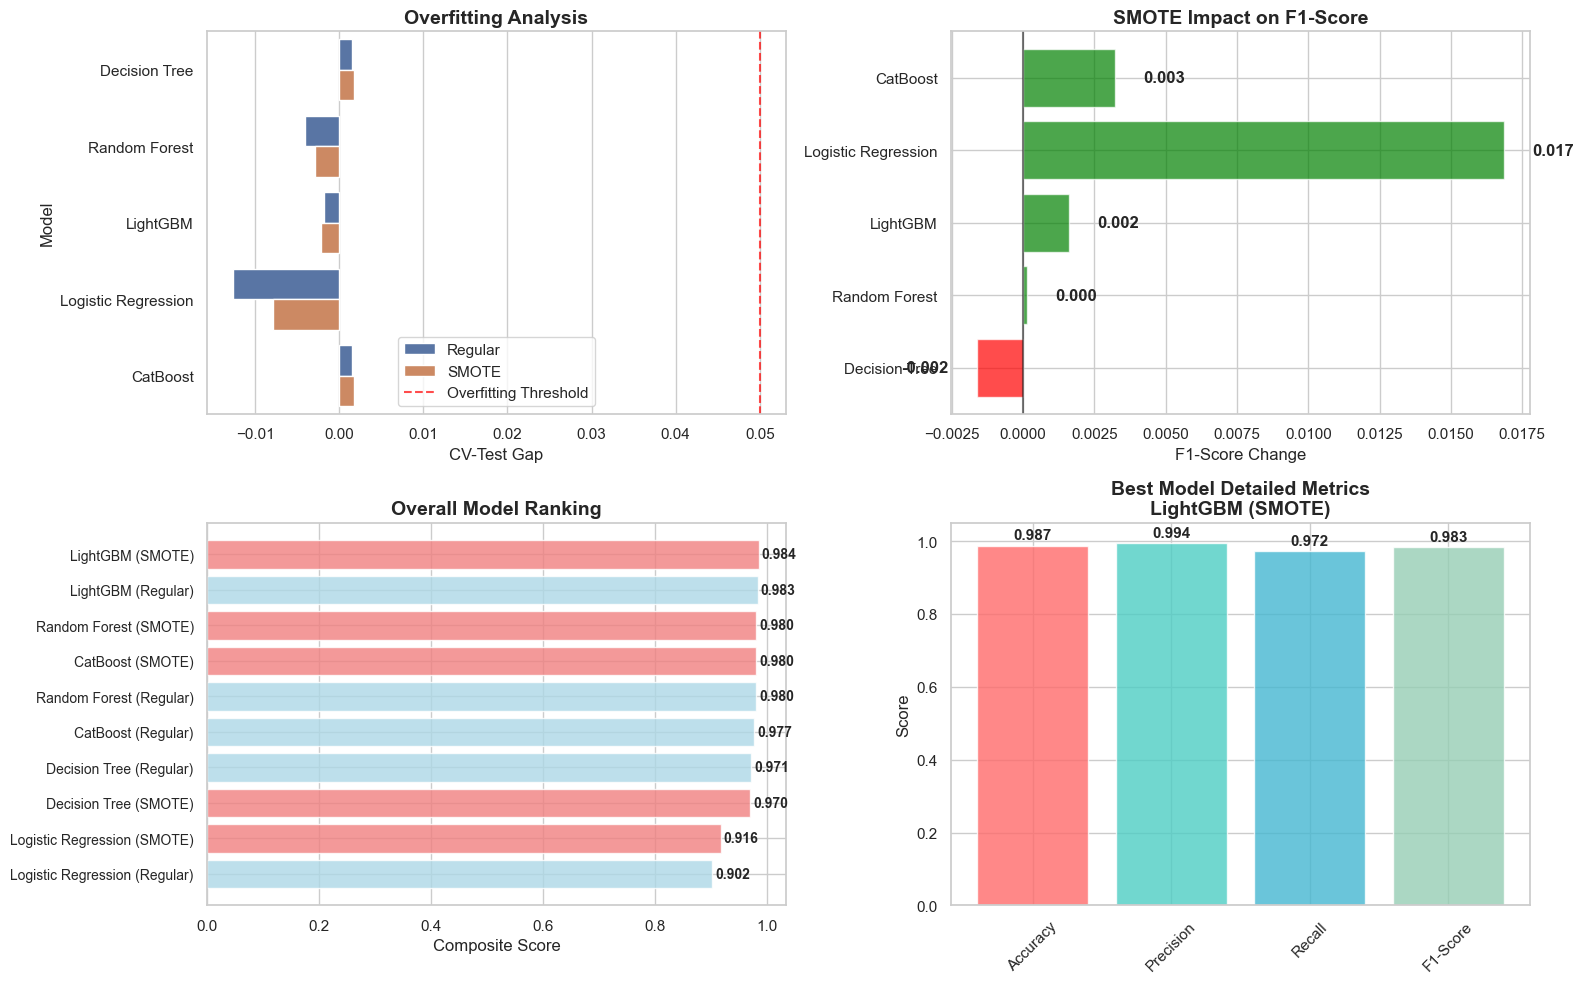


KEY INSIGHTS & RECOMMENDATIONS:
--------------------------------------------------
1. Best Overall Model: LightGBM with SMOTE dataset
2. SMOTE is most effective for: Logistic Regression
3. Most Balanced Model: Logistic Regression
4. Next Steps: Hyperparameter tuning for top 3 models, ensemble methods

Results saved to 'enhanced_model_comparison_results.csv'


In [102]:
results_df = pd.DataFrame(results)

print("\n" + "="*80)
print("MACHINE LEARNING MODEL COMPARISON SUMMARY")
print("="*80)

print("\nComplete Performance Summary:")
display_df = results_df.copy()
for col in ['CV Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1-Score']:
    display_df[col] = display_df[col].apply(lambda x: f"{x:.4f}")
display_df['CV-Test Gap'] = display_df['CV-Test Gap'].apply(lambda x: f"{x:.4f}")

print(display_df[['Model', 'Dataset', 'CV Accuracy', 'Test Accuracy', 'CV-Test Gap', 'Precision', 'Recall', 'F1-Score']].to_string(index=False))

print("\nBEST PERFORMERS BY METRIC:")
print("-" * 50)

metrics = ['Test Accuracy', 'Precision', 'Recall', 'F1-Score']
best_models = {}

for metric in metrics:
    best_idx = results_df[metric].idxmax()
    best_result = results_df.iloc[best_idx]
    best_models[metric] = best_result
    print(f"Best {metric}: {best_result['Model']} ({best_result['Dataset']}) = {best_result[metric]:.4f}")

overall_best = best_models['F1-Score']
print(f"\nRECOMMENDED MODEL: {overall_best['Model']} with {overall_best['Dataset']} dataset")
print(f"   Test Accuracy: {overall_best['Test Accuracy']:.4f}")
print(f"   Precision: {overall_best['Precision']:.4f}")
print(f"   Recall: {overall_best['Recall']:.4f}")
print(f"   F1-Score: {overall_best['F1-Score']:.4f}")

print(f"\nSMOTE DATASET IMPACT ANALYSIS:")
print("-" * 50)
models_list = results_df['Model'].unique()
for model in models_list:
    regular_data = results_df[(results_df['Model'] == model) & (results_df['Dataset'] == 'Regular')]
    smote_data = results_df[(results_df['Model'] == model) & (results_df['Dataset'] == 'SMOTE')]
    
    if len(regular_data) > 0 and len(smote_data) > 0:
        regular_f1 = regular_data['F1-Score'].iloc[0]
        smote_f1 = smote_data['F1-Score'].iloc[0]
        improvement = smote_f1 - regular_f1
        
        if improvement > 0.01:
            print(f"{model}: SMOTE improved F1-Score by {improvement:.4f} ({improvement*100:.1f}%)")
        elif improvement < -0.01:
            print(f"{model}: SMOTE decreased F1-Score by {abs(improvement):.4f} ({abs(improvement)*100:.1f}%)")
        else:
            print(f"{model}: SMOTE had minimal impact ({improvement:.4f})")

print(f"\nOVERFITTING ANALYSIS (CV-Test Gap > 0.05):")
print("-" * 50)
overfitting = results_df[results_df['CV-Test Gap'] > 0.05]
if len(overfitting) > 0:
    for _, row in overfitting.iterrows():
        print(f"{row['Model']} ({row['Dataset']}): Gap = {row['CV-Test Gap']:.4f} - Consider regularization")
else:
    print("No significant overfitting detected in any model!")

plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
sns.barplot(data=results_df, x='CV-Test Gap', y='Model', hue='Dataset', orient='h')
plt.axvline(x=0.05, color='red', linestyle='--', alpha=0.7, label='Overfitting Threshold')
plt.xlabel('CV-Test Gap')
plt.title('Overfitting Analysis', fontsize=14, fontweight='bold')
plt.legend()

plt.subplot(2, 2, 2)
impact_data = []
for model in models_list:
    regular_f1 = results_df[(results_df['Model'] == model) & (results_df['Dataset'] == 'Regular')]['F1-Score'].iloc[0]
    smote_f1 = results_df[(results_df['Model'] == model) & (results_df['Dataset'] == 'SMOTE')]['F1-Score'].iloc[0]
    impact = smote_f1 - regular_f1
    impact_data.append({'Model': model, 'SMOTE_Impact': impact})

impact_df = pd.DataFrame(impact_data)
colors = ['green' if x > 0 else 'red' for x in impact_df['SMOTE_Impact']]
bars = plt.barh(impact_df['Model'], impact_df['SMOTE_Impact'], color=colors, alpha=0.7)

for bar, value in zip(bars, impact_df['SMOTE_Impact']):
    plt.text(value + (0.001 if value >= 0 else -0.001), bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}', ha='left' if value >= 0 else 'right', va='center', fontweight='bold')

plt.xlabel('F1-Score Change')
plt.title('SMOTE Impact on F1-Score', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)

plt.subplot(2, 2, 3)
results_df['Composite_Score'] = (results_df['Test Accuracy'] * 0.3 + 
                                results_df['Precision'] * 0.25 + 
                                results_df['Recall'] * 0.25 + 
                                results_df['F1-Score'] * 0.2)

ranking_df = results_df.copy()
ranking_df['Model_Dataset'] = ranking_df['Model'] + ' (' + ranking_df['Dataset'] + ')'
ranking_df = ranking_df.sort_values('Composite_Score', ascending=True)

colors = ['lightblue' if 'Regular' in x else 'lightcoral' for x in ranking_df['Model_Dataset']]
bars = plt.barh(range(len(ranking_df)), ranking_df['Composite_Score'], color=colors, alpha=0.8)

for i, (bar, score) in enumerate(zip(bars, ranking_df['Composite_Score'])):
    plt.text(score + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{score:.3f}', ha='left', va='center', fontweight='bold', fontsize=10)

plt.yticks(range(len(ranking_df)), ranking_df['Model_Dataset'], fontsize=10)
plt.xlabel('Composite Score')
plt.title('Overall Model Ranking', fontsize=14, fontweight='bold')

plt.subplot(2, 2, 4)
top_model = results_df.loc[results_df['F1-Score'].idxmax()]
metrics_values = [top_model['Test Accuracy'], top_model['Precision'], 
                 top_model['Recall'], top_model['F1-Score']]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

bars = plt.bar(metric_names, metrics_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'], alpha=0.8)

for bar, value in zip(bars, metrics_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.ylim(0, 1.05)
plt.title(f'Best Model Detailed Metrics\n{top_model["Model"]} ({top_model["Dataset"]})', 
          fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"\nKEY INSIGHTS & RECOMMENDATIONS:")
print("-" * 50)
print(f"1. Best Overall Model: {overall_best['Model']} with {overall_best['Dataset']} dataset")
print(f"2. SMOTE is most effective for: {impact_df.loc[impact_df['SMOTE_Impact'].idxmax(), 'Model']}")
print(f"3. Most Balanced Model: {results_df.loc[(results_df['Precision'] - results_df['Recall']).abs().idxmin(), 'Model']}")
print(f"4. Next Steps: Hyperparameter tuning for top 3 models, ensemble methods")

print(f"\nResults saved to 'enhanced_model_comparison_results.csv'")
print("="*80)

---

# Final Conclusion for Loan Prediction Notebook

---
Based on the analysis, the LightGBM model trained on the SMOTE dataset emerges as the best overall performer for loan prediction, achieving a test accuracy of 0.9871, precision of 0.9937, recall of 0.9721, and an F1-score of 0.9828. The minimal CV-Test gap of -0.0022 indicates no significant overfitting, and the SMOTE technique contributed a modest improvement of 0.0016 to the F1-score. While Logistic Regression benefited most from SMOTE with a 1.7% F1-score increase, its overall performance (0.9321 test accuracy) lags behind LightGBM. The lack of overfitting across all models supports their robustness. Future steps should focus on hyperparameter tuning for LightGBM, Random Forest, and CatBoost, alongside exploring ensemble methods to further enhance predictive power.